## FORMULA 1

- In this jupyter notebook, I attempt to apply machine learning alogirthms to a few Formula 1 scenarios
    - a) Binary Classification: Predict race finishes (ie. Did a driver finish a race?)
    - b) Binary Classifiation (of multiple target variables): Predict tyre set combinations each driver will use at each race.
    - c) Multi-label Classifiation: Predict tyre set combinations each driver will use at each race. (To be updated in the future...)
    
- Early challenges in starting this project was that fact that I do not have a prepared full dataset of features. I had to create a dataset myself. This involves creating a template of race participants for the 2015 to 2017 season, then merging features to this template. Furthermore, all features were engineered.

- Next challenge was the fact that i had to deal with 20 races per season. This means that the training dataset is built up as the season progresses. This increases variability of prediction estimation. Furthermore, it makes code execution (particulatly tuning of classifiers) computationally more expensive. 

- Section B to D of the notebook is filled with code of all functions requried to create dataset and then conduct model-fitting and generating predictions. (I have made the functions as 'recyclable' as possible for future seasons). Section E is where the meat lies: the prediction results. 

- As i did not want to bloat this notebook, I have placed all data visualizations (EDA, prediction results) in a separate notebook titled "FORMULA 1: DATA VISUALIZATION"

In [192]:
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from itertools import groupby
import pickle
import os
import math
from sympy import S, symbols
from collections import Counter
import sklearn 
from sklearn import preprocessing

pd.options.mode.chained_assignment = None 

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')
#sns.mpl.rcParams['figure.figsize'] = (16, 10)

# Directory to store pickled dataframes
directory = '/Users/dianaow/Documents/formula-1-race-data/dataframes/'

In [153]:
import statsmodels.api as sm
from sklearn.metrics import r2_score , mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.utils import resample
from sklearn.utils import class_weight

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, accuracy_score, precision_score, average_precision_score, \
classification_report, recall_score, confusion_matrix, f1_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks

import statsmodels.graphics.regressionplots 
import mord as mord
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import KFold 
from sklearn.base import clone

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
def read_from_pickle(directory, filename):
    df = pd.DataFrame()
    filepath = directory + filename
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
            
    return df

## Section A: Create template to build dataset of features (predictors)

#### Word of caution before building dataset:

- Race list is constant between 2016 and 2017.
- Driver list is not constant between 2016 and 2017.
- Retired: Rosberg, Button
- New in 2017: Stroll, Vandoorne (participated in one race in 2016), Ocon (participated one race in 2016), Hulkenberg, Wehrlein
- No longer participating in 2017: Haryanto, Nasr, Gutierrez
- Mid-season team switches.
    - In 2017, Sainz switched from Torro Rosso to Renault starting from US GP.
    - In 2016, Kvyat switched from Torro Rosso to Red Bull starting from Spanish GP.
    - In 2016, Verstappen switched from Red Bull to Torro Rosso starting from Spanish GP.
- Dropped mid-season. 
    - Haryanto (2016), Kvyat (2017), Palmer (2017)
- Added mid-season. 
    - Ocon (2016, from Belgian GP), Gasly (2017, from Malaysian GP), Hartley (2017, from US GP)
- Reserve drivers who substituted:
    - 2016 Bahrain GP -> Vandoorne subbed for Alonso
    - 2017 Monaco GP -> Button subbed for Alonso
    - 2017 Hungarian GP -> Di Resta subbed for Massa

These driver switches will causes some confusion in putting together the final dataset. Always check! 

In [5]:
ALL151617_startstint = read_from_pickle(directory, "ALL151617_startstint.pickle")
df_drivers_2015 = read_from_pickle(directory, "df_drivers_2015.pickle")
df_drivers_2016 = read_from_pickle(directory, "df_drivers_2016.pickle")
df_drivers_2017 = read_from_pickle(directory, "df_drivers_2017.pickle")
df_races = read_from_pickle(directory, "df_races.pickle")

In [6]:
df_results = pd.read_csv('./formula-1-race-data/results.csv')

In [7]:
drivers_2015 = list(df_drivers_2015.driverRef.unique()) 
drivers_2015.remove('magnussen') # remove magnussen because he only participated in 1 race in 2016
# both drivers didn't complete the entire season. since manor is no longer an existing team, remove these drivers
drivers_2015.remove('rossi') 
drivers_2015.remove('merhi')
#drivers_2015.remove('stevens') 

drivers_2016 = list(df_drivers_2016.driverRef.unique()) 
drivers_2016.remove('vandoorne') # remove vandoorne because he only participated in 1 race in 2016
drivers_2016.remove('haryanto')
drivers_2016.remove('ocon')

drivers_2017 = list(df_drivers_2017.driverRef.unique())
# remove giovinazzi, gasly, hartley, button, di resta because they only participated in races one-off in 2017
drivers_2017.remove('button')
drivers_2017.remove('giovinazzi')
drivers_2017.remove('di resta')
drivers_2017.remove('palmer')
drivers_2017.remove('gasly')
drivers_2017.remove('kvyat')
drivers_2017.remove('brendon_hartley')

# Standardize: Use the same number of races in 2017
races15 = list(df_races[df_races['year'] == 2015].name.unique())
races = list(df_races[df_races['year'] == 2017].name.unique())
stints = range(1,5)

template15 = pd.DataFrame(list(itertools.product([2015], races15, drivers_2015)), columns=['year', 'name', 'driverRef'])
template16 = pd.DataFrame(list(itertools.product([2016], races, drivers_2016)), columns=['year', 'name', 'driverRef'])
template17 = pd.DataFrame(list(itertools.product([2017], races, drivers_2017)), columns=['year', 'name', 'driverRef'])

drivers_2017_new = ['gasly', 'kvyat', 'brendon_hartley']

temp_har = pd.DataFrame(list(itertools.product([2016], ['Australian Grand Prix',
                                                         'Chinese Grand Prix',
                                                         'Bahrain Grand Prix',
                                                         'Russian Grand Prix',
                                                         'Spanish Grand Prix',
                                                         'Monaco Grand Prix',
                                                         'Canadian Grand Prix',
                                                         'Azerbaijan Grand Prix',
                                                         'Austrian Grand Prix',
                                                         'British Grand Prix',
                                                         'Hungarian Grand Prix'] ,\
                        ["haryanto"])), columns=['year', 'name', 'driverRef'])

temp_ocon = pd.DataFrame(list(itertools.product([2016], ['Belgian Grand Prix',
                                                         'Italian Grand Prix',
                                                         'Singapore Grand Prix',
                                                         'Malaysian Grand Prix',
                                                         'Japanese Grand Prix',
                                                         'United States Grand Prix',
                                                         'Mexican Grand Prix',
                                                         'Brazilian Grand Prix',
                                                         'Abu Dhabi Grand Prix'],\
                        ["ocon"])), columns=['year', 'name', 'driverRef'])

temp_gasly = pd.DataFrame(list(itertools.product([2017], ['Malaysian Grand Prix',
                                                         'Japanese Grand Prix',
                                                         'Mexican Grand Prix',
                                                         'Brazilian Grand Prix',
                                                         'Abu Dhabi Grand Prix'],\
                        ["gasly"])), columns=['year', 'name', 'driverRef'])

temp_hartley = pd.DataFrame(list(itertools.product([2017], ['United States Grand Prix',
                                                             'Mexican Grand Prix',
                                                             'Brazilian Grand Prix',
                                                             'Abu Dhabi Grand Prix'],\
                        ["brendon_hartley"])), columns=['year', 'name', 'driverRef'])

temp_kvyat = pd.DataFrame(list(itertools.product([2017], ['Australian Grand Prix',
                                                             'Chinese Grand Prix',
                                                             'Bahrain Grand Prix',
                                                             'Russian Grand Prix',
                                                             'Spanish Grand Prix',
                                                             'Monaco Grand Prix',
                                                             'Canadian Grand Prix',
                                                             'Azerbaijan Grand Prix',
                                                             'Austrian Grand Prix',
                                                             'British Grand Prix',
                                                             'Hungarian Grand Prix',
                                                             'Belgian Grand Prix',
                                                             'Italian Grand Prix',
                                                             'Singapore Grand Prix',
                                                             'United States Grand Prix'] ,\
                        ["kvyat"])), columns=['year', 'name', 'driverRef'])


temp_palmer = pd.DataFrame(list(itertools.product([2017], ['Australian Grand Prix',
                                                             'Chinese Grand Prix',
                                                             'Bahrain Grand Prix',
                                                             'Russian Grand Prix',
                                                             'Spanish Grand Prix',
                                                             'Monaco Grand Prix',
                                                             'Canadian Grand Prix',
                                                             'Azerbaijan Grand Prix',
                                                             'Austrian Grand Prix',
                                                             'British Grand Prix',
                                                             'Hungarian Grand Prix',
                                                             'Belgian Grand Prix',
                                                             'Italian Grand Prix',
                                                             'Singapore Grand Prix',
                                                             'Malaysian Grand Prix'] ,\
                        ["palmer"])), columns=['year', 'name', 'driverRef'])
                                                               
                                                               
        
# Create a new dataframe with the actual race information of these replacement/one-off drivers

from itertools import product

replacements = pd.DataFrame({'year': [2016, 2017, 2017, 2017, 2017], 
                             'name': ["Bahrain Grand Prix", "Australian Grand Prix", "Chinese Grand Prix", "Monaco Grand Prix", "Hungarian Grand Prix"], 
                             'driverRef': ['vandoorne', 'giovinazzi', 'giovinazzi', "button", "di resta"]
                             })

template = pd.concat([template15, template16, template17, temp_har, temp_ocon, temp_gasly, temp_hartley, temp_kvyat, temp_palmer])

In [8]:
# Merge constructor Ids to template
dcrm = read_from_pickle(directory, "dcrm.pickle")
template_dcrm = pd.merge(template, dcrm[['year', 'name', 'driverRef', 'constructorRef', 'constructorId']], on=['year', 'name', 'driverRef'], how='left')

# Note there are null values because these drivers did not participate in the respective races for once or twice only. 
# Inpute their constructordIds
template_dcrm[template_dcrm['constructorRef'].isnull()].drop_duplicates(subset=['year', 'name', 'driverRef'], keep='first')

,year,name,driverRef,constructorRef,constructorId
112,2015,Australian Grand Prix,alonso,NaN,NaN
113,2015,Australian Grand Prix,stevens,NaN,NaN
422,2016,Bahrain Grand Prix,alonso,NaN,NaN
798,2017,Australian Grand Prix,wehrlein,NaN,NaN
816,2017,Chinese Grand Prix,wehrlein,NaN,NaN
882,2017,Monaco Grand Prix,alonso,NaN,NaN
966,2017,Hungarian Grand Prix,massa,NaN,NaN


In [9]:
template_dcrm.loc[112,"constructorRef"] = 'mclaren'
template_dcrm.loc[113,"constructorRef"] = 'manor'
template_dcrm.loc[422,"constructorRef"] = 'mclaren'
template_dcrm.loc[798, "constructorRef"] = 'sauber'
template_dcrm.loc[816, "constructorRef"] = 'sauber'
template_dcrm.loc[882, "constructorRef"] = 'mclaren'
template_dcrm.loc[966,"constructorRef"] = 'williams'

template_dcrm.loc[112,"constructorId"] = 1
template_dcrm.loc[113,"constructorId"] = 209
template_dcrm.loc[422,"constructorId"] = 1
template_dcrm.loc[798, "constructorId"] = 15
template_dcrm.loc[816, "constructorId"] = 15
template_dcrm.loc[882, "constructorId"] = 1
template_dcrm.loc[966,"constructorId"] = 3

template_dcrm.replace("brendon_hartley", "hartley", inplace=True)

In [10]:
template17 = template_dcrm[template_dcrm['year'] == 2017]

### Subset dataset template

#### Pirelli chooses tyre compounds for each track. No less than nine weeks before the start of each event in Europe, and 15 weeks before the start of each event held outside Europe, Pirelli will inform teams which three compounds are to be used at each race. A race may not be allocated the same combination for consecutive seasons. The choice of tyre compound combinations is important in shaping race strategy.

#### Pirelli's possible tyre combinations for the 2017 session are as follows:
- Super soft, Soft, Medium -> Category 1
- Soft, Medium, Hard -> Category 2
- Super soft, Soft, Ultra soft -> Category 3

In [11]:
xl = pd.ExcelFile("/Users/dianaow/Downloads/F1_Tyre_data.xlsx")
xl.sheet_names
pirelli = xl.parse("Sheet7")

In [12]:
# Pirelli dataframe: Dataframe containing Pirelli's allocated mandatory tyre set for each race for 2015, 2016, 2017 season
# Label each selected set
# SS, S, M = 1
# S, M, H = 2
# SS, S, US = 3

for i,row in pirelli.iterrows(): 
    if (pirelli.loc[i,'Super Soft'] == 'Super Soft') & (pirelli.loc[i,'Soft'] == 'Soft') & (pirelli.loc[i,'Medium'] == "Medium"):  
        pirelli.loc[i,'mandatory combi'] = float(1)
    elif (pirelli.loc[i,'Soft'] == "Soft") & (pirelli.loc[i,'Medium'] == "Medium") & (pirelli.loc[i,'Hard'] == "Hard"):
        pirelli.loc[i,'mandatory combi'] = float(2)
    elif (pirelli.loc[i,'Super Soft'] == 'Super Soft') & (pirelli.loc[i,'Soft'] == 'Soft') & (pirelli.loc[i,'Ultra Soft'] == 'Ultra Soft'):
        pirelli.loc[i,'mandatory combi'] = float(3)
    elif (pirelli.loc[i,'Super Soft'] == 'Super Soft') & (pirelli.loc[i,'Soft'] == 'Soft') & (pirelli.loc[i,'Medium'] != "Medium"): 
        pirelli.loc[i,'mandatory combi'] = float(4)
    elif (pirelli.loc[i,'Super Soft'] != 'Super Soft') & (pirelli.loc[i,'Soft'] == 'Soft') & (pirelli.loc[i,'Medium'] != "Medium"): 
        pirelli.loc[i,'mandatory combi'] = float(5)
    elif (pirelli.loc[i,'Super Soft'] != 'Soft') & (pirelli.loc[i,'Medium'] == "Medium") & (pirelli.loc[i,'Hard'] == "Hard"): 
        pirelli.loc[i,'mandatory combi'] = float(6)
    else:
        pirelli.loc[i,'mandatory combi'] = float(7)

#### Races allocated Combination 1

In [13]:
p1 = pirelli[pirelli['mandatory combi'] == 1].sort_values(['name', 'year'])
p1_2017_races = list(p1[p1['year'] == 2017].name.unique()) # Races are sorted in alphabetical order
p1_2017_races.sort(key=lambda x: races.index(x)) # Sort races according to the race calendar!
p1_races = p1[['year', 'name']].to_dict('list')
p1
# Note: It is not always that a race will be allocated the same tyre combination between years.
# For eg. 2016 Brazilian GP: combi 2, 2017 Brazilian GP: combi 1

,year,name,Super Soft,Soft,Medium,Hard,Ultra Soft,mandatory combi
0,2016,Australian Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
7,2016,Azerbaijan Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
47,2017,Azerbaijan Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
1,2016,Bahrain Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
42,2017,Bahrain Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
13,2016,Belgian Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
58,2017,Brazilian Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
49,2017,British Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
2,2016,Chinese Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0
41,2017,Chinese Grand Prix,Super Soft,Soft,Medium,NaN,NaN,1.0


#### Races allocated Combination 2

In [14]:
p2 = pirelli[pirelli['mandatory combi'] == 2].sort_values(['name', 'year'])
p2_2017_races = list(p2[p2['year'] == 2017].name.unique())
p2_2017_races.sort(key=lambda x: races.index(x)) # Sort races according to the race calendar!
p2_races = p2[['year', 'name']].to_dict('list')
p2

,year,name,Super Soft,Soft,Medium,Hard,Ultra Soft,mandatory combi
19,2016,Brazilian Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0
9,2016,British Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0
16,2016,Japanese Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0
15,2016,Malaysian Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0
4,2016,Spanish Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0
44,2017,Spanish Grand Prix,NaN,Soft,Medium,Hard,NaN,2.0


#### Races allocated Combination 3

In [15]:
p3 = pirelli[pirelli['mandatory combi'] == 3].sort_values(['name', 'year'])
p3_2017_races = list(p3[p3['year'] == 2017].name.unique())
p3_2017_races.sort(key=lambda x: races.index(x)) # Sort races according to the race calendar!
p3_races = p3[['year', 'name']].to_dict('list')
p3

,year,name,Super Soft,Soft,Medium,Hard,Ultra Soft,mandatory combi
20,2016,Abu Dhabi Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
59,2017,Abu Dhabi Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
40,2017,Australian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
8,2016,Austrian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
48,2017,Austrian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
51,2017,Belgian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
6,2016,Canadian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
46,2017,Canadian Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
57,2017,Mexican Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0
5,2016,Monaco Grand Prix,Super Soft,Soft,NaN,NaN,Ultra Soft,3.0


In [16]:
races_dict = pirelli[['year', 'name']].to_dict('list')

In [17]:
p1.to_pickle(os.path.join(directory,  "p1.pickle"))
p2.to_pickle(os.path.join(directory,  "p2.pickle"))
p3.to_pickle(os.path.join(directory,  "p3.pickle"))
pirelli.to_pickle(os.path.join(directory,  "pirelli.pickle"))

In [18]:
# List of drivers participating in 2015 to 2017 seasons

df_drivers = df_drivers_2015.append(df_drivers_2016)
df_drivers = df_drivers.append(df_drivers_2017)
df_drivers = df_drivers.drop_duplicates(subset=['driverId', 'driverRef'], keep='first')

In [19]:
# Race finish position numbers of drivers

finish_pos = df_results[['raceId', 'driverId', 'position']]
finish_pos = pd.merge(finish_pos, df_races[['raceId', "name", 'year']], on='raceId', how='left')
finish_pos = pd.merge(finish_pos, df_drivers, on='driverId', how='left')
finish_pos = finish_pos[finish_pos['year'].isin([2015,2016,2017])]
finish_pos.drop(['raceId', 'driverId'], axis=1, inplace=True)
finish_pos.to_pickle(os.path.join(directory,  "finish_pos.pickle"))

# Section B: Features / Predictors

IMPORTANT: We can only include features that are known before a race. (Note: Qualification results can be a feature of the model if we plan to perform the classification after qualification and before a race.) 

PLEASE REFER TO JUPYTER NOTEBOOK TITLED 'FORMULA 1: DATA VISUALIZATION' FOR DETAILED VISUALIATION OF FEATURES!

## Features that are the ground truth

### 1) Feature: Team driver belongs to 

In [20]:
# Label teams before dummy coding

top_field = ['mercedes', 'ferrari', 'red_bull']
mid_field = ['haas', 'toro_rosso', 'mclaren', 'williams', 'force_india']
bottom_field = ['manor', 'sauber', 'renault']

teams_cat_top = dict((i, "top") for i in top_field)
teams_cat_mid = dict((i, "middle") for i in mid_field)
teams_cat_bottom = dict((i, "bottom") for i in bottom_field)

def merge_dicts(x, y, z):
    M = x.copy()   # start with x's keys and values
    M.update(y)    # modifies z with y's keys and values & returns None
    M.update(z)
    
    return M

team_cat = merge_dicts(teams_cat_top, teams_cat_mid, teams_cat_bottom)

In [21]:
template_dcrm['team category'] = template_dcrm['constructorRef'].map(team_cat)
template17['team category'] = template17['constructorRef'].map(team_cat)

In [22]:
team_cat_dummies = pd.get_dummies(template_dcrm, columns=["team category"], drop_first=True)

### 2) Feature: Driver's Qualification Position

In [23]:
df_qualifying = pd.read_csv('./formula-1-race-data/qualifying.csv')

qual_pos = df_qualifying[['raceId', 'driverId', 'position']]
qual_pos = pd.merge(qual_pos, df_races[['raceId', "name", 'year']], on='raceId', how='left')
qual_pos = pd.merge(qual_pos, df_drivers, on='driverId', how='left')
qual_pos = qual_pos[qual_pos['year'].isin([2015,2016,2017])]
qual_pos.drop(['raceId', 'driverId'], axis=1, inplace=True)
qual_pos.to_pickle(os.path.join(directory,  "qual_pos.pickle"))

In [24]:
qual_pos.head()

,position,name,year,driverRef
6286,1,Australian Grand Prix,2015,hamilton
6287,2,Australian Grand Prix,2015,rosberg
6288,3,Australian Grand Prix,2015,massa
6289,4,Australian Grand Prix,2015,vettel
6290,5,Australian Grand Prix,2015,raikkonen


### 3) Feature: Selected tyre sets of each driver for each race
- Published by Pirelli 2 weeks before each race
- Some 2016 or 2017 races do not have this information published by Pirelli online. -> 2016 Italian Grand Prix, 2016 Mexican Grand Prix, 2017 Australian Grand Prix, 2017 Bahrain Grand Prix, 2017 Russian Grand Prix, 2017 Chinese Grand Prix
- Approach 1: Inpute these values with the average count of tyres selected for each tyre type for races assigned the same mandatory tyre sets. 
- Approach 2:
    - If Pirelli's assigned tyre combination for the track is same for both 2016 and 2017, missing 2017 values will be inputed with the previous year's data. Missing 2016 values will be inputed with next year's data
    - If Pirelli's assigned tyre combination for the track is not the same for both 2016 and 2017, missing 2017 values will be inputed with the previous year's data in the order of the softness of the tyre compounds available
- Choose Approach 2 because the ratio of tyre compounds selected is track-specific

#### Approach 1

In [25]:
xl = pd.ExcelFile("./formula-1-race-data/Selected_Sets.xlsx", encoding='utf-8')
xl.sheet_names
selected_sets1 = xl.parse("Selected_Sets_Copy")

In [26]:
selected_sets1.head()

,year,name,driverRef,Medium,Soft,Super Soft,Ultra soft,Hard
0,2017,Brazilian Grand Prix,vettel,1,3,9,0,0
1,2017,Brazilian Grand Prix,bottas,1,4,8,0,0
2,2017,Brazilian Grand Prix,raikkonen,1,3,9,0,0
3,2017,Brazilian Grand Prix,hamilton,1,4,8,0,0
4,2017,Brazilian Grand Prix,verstappen,1,3,9,0,0


#### Approach 2

In [27]:
xl = pd.ExcelFile("./formula-1-race-data/Selected_Sets.xlsx", encoding='utf-8')
xl.sheet_names
selected_sets = xl.parse("Selected_Sets_Copy")

In [28]:
selected_sets['tyre combi'] = selected_sets[["Medium", "Soft", "Super Soft", "Ultra soft", "Hard"]].values.tolist()
selected_sets['tyre combi'] = [tuple(x) for x in selected_sets['tyre combi']]
selected_sets = selected_sets[['year', 'name', 'driverRef', 'tyre combi']]

In [29]:
selected_sets = pd.merge(selected_sets, pirelli[['year', 'name', 'mandatory combi']], on=['year', 'name'], how='left')

In [30]:
selected_sets[(selected_sets['name'] == "Spanish Grand Prix") & (selected_sets['year'] == 2017)]

,year,name,driverRef,tyre combi,mandatory combi
280,2017,Spanish Grand Prix,hamilton,"(1, 5, 7, 0, 0)",2.0
281,2017,Spanish Grand Prix,bottas,"(1, 5, 7, 0, 0)",2.0
282,2017,Spanish Grand Prix,ricciardo,"(2, 4, 7, 0, 0)",2.0
283,2017,Spanish Grand Prix,verstappen,"(2, 4, 7, 0, 0)",2.0
284,2017,Spanish Grand Prix,vettel,"(1, 4, 8, 0, 0)",2.0
285,2017,Spanish Grand Prix,raikkonen,"(1, 4, 8, 0, 0)",2.0
286,2017,Spanish Grand Prix,perez,"(2, 5, 6, 0, 0)",2.0
287,2017,Spanish Grand Prix,ocon,"(2, 5, 6, 0, 0)",2.0
288,2017,Spanish Grand Prix,massa,"(1, 5, 7, 0, 0)",2.0
289,2017,Spanish Grand Prix,stroll,"(1, 5, 7, 0, 0)",2.0


In [31]:
sets_group = selected_sets.groupby(['tyre combi']).agg({"driverRef":"count"}).reset_index()
sets_group['freq'] = sets_group['driverRef'] / len(selected_sets)
print len(sets_group)

sets_group_top95 = sets_group[sets_group['freq'] >= 0.05]
sets_group_top95

73


,tyre combi,driverRef,freq
1,"(0, 1, 2, 10, 0)",49,0.058333
22,"(1, 2, 10, 0, 0)",42,0.050000
23,"(1, 3, 9, 0, 0)",48,0.057143
24,"(1, 4, 8, 0, 0)",52,0.061905
26,"(1, 5, 7, 0, 0)",72,0.085714
35,"(2, 4, 7, 0, 0)",45,0.053571


In [32]:
sets_group_yn = selected_sets.groupby(['year', 'name', 'tyre combi']).agg({"driverRef":"count"}).reset_index()
sets_group_yn = pd.merge(sets_group_yn, pirelli[['year', 'name', 'mandatory combi']], on=['year', 'name'], how='left')

In [33]:
sets1 = sets_group_yn[sets_group_yn['mandatory combi'] == 1].reset_index(drop=True)
sets2 = sets_group_yn[sets_group_yn['mandatory combi'] == 2].reset_index(drop=True)
sets3 = sets_group_yn[sets_group_yn['mandatory combi'] == 3].reset_index(drop=True)

In [34]:
sets1_g = sets1.groupby('tyre combi').agg({"driverRef":"sum"}).reset_index()
sets1_g['freq'] = sets1_g['driverRef'] / sum(sets1_g['driverRef'])
sets1_g_top90 = sets1_g[sets1_g['freq'] >= 0.10]
sets1_g_top90

,tyre combi,driverRef,freq
1,"(1, 2, 10, 0, 0)",42,0.1050
2,"(1, 3, 9, 0, 0)",48,0.1200
3,"(1, 4, 8, 0, 0)",50,0.1250
4,"(1, 5, 7, 0, 0)",65,0.1625
12,"(2, 4, 7, 0, 0)",43,0.1075


In [35]:
sets2_g = sets2.groupby('tyre combi').agg({"driverRef":"sum"}).reset_index()
sets2_g['freq'] = sets2_g['driverRef'] / sum(sets2_g['driverRef'])
sets2_g_top90 = sets2_g[sets2_g['freq'] >= 0.10]
sets2_g_top90

,tyre combi,driverRef,freq
23,"(4, 7, 0, 0, 2)",14,0.107692
25,"(4, 8, 0, 0, 1)",13,0.100000
27,"(5, 7, 0, 0, 1)",24,0.184615


In [36]:
sets3_g = sets3.groupby('tyre combi').agg({"driverRef":"sum"}).reset_index()
sets3_g['freq'] = sets3_g['driverRef'] / sum(sets3_g['driverRef'])
sets3_g_top90 = sets3_g[sets3_g['freq'] >= 0.10]
sets3_g_top90

,tyre combi,driverRef,freq
1,"(0, 1, 2, 10, 0)",49,0.158065
2,"(0, 1, 3, 9, 0)",31,0.100000
9,"(0, 2, 4, 7, 0)",32,0.103226


In [37]:
cols_to_keep = ['year', 'name', 'driverRef', 'mandatory combi', 'tyre combi_(1, 2, 10, 0, 0)', 'tyre combi_(1, 3, 9, 0, 0)',\
                'tyre combi_(1, 4, 8, 0, 0)', 'tyre combi_(1, 5, 7, 0, 0)', 'tyre combi_(2, 4, 7, 0, 0)',\
                'tyre combi_(4, 7, 0, 0, 2)', 'tyre combi_(4, 8, 0, 0, 1)', 'tyre combi_(5, 7, 0, 0, 1)',\
                'tyre combi_(0, 1, 2, 10, 0)', 'tyre combi_(0, 1, 3, 9, 0)', 'tyre combi_(0, 2, 4, 7, 0)']

In [38]:
sets_dummies = pd.get_dummies(selected_sets, columns=["tyre combi"])

In [39]:
sets_dummies_trunc = sets_dummies[cols_to_keep]

In [40]:
selected_sets_all = pd.merge(selected_sets, sets_dummies, on=['year', 'name', 'driverRef', 'mandatory combi'], how='left')

In [41]:
mand_combi_dummies = pd.get_dummies(selected_sets, columns=["mandatory combi"], drop_first=True)

In [42]:
selected_sets_all = pd.merge(selected_sets_all, mand_combi_dummies, on=['year', 'name', 'driverRef', 'tyre combi'], how='left')
selected_sets_all.drop(['tyre combi','mandatory combi'], axis=1, inplace=True)

In [43]:
selected_sets_all.head()

,year,name,driverRef,"tyre combi_(0, 1, 1, 11, 0)","tyre combi_(0, 1, 2, 10, 0)","tyre combi_(0, 1, 3, 9, 0)","tyre combi_(0, 1, 4, 8, 0)","tyre combi_(0, 1, 5, 7, 0)","tyre combi_(0, 1, 6, 6, 0)","tyre combi_(0, 2, 1, 10, 0)",...,"tyre combi_(4, 7, 0, 2, 0)","tyre combi_(4, 8, 0, 0, 1)","tyre combi_(5, 2, 6, 0, 0)","tyre combi_(5, 4, 4, 0, 0)","tyre combi_(5, 6, 0, 0, 2)","tyre combi_(5, 7, 0, 0, 1)","tyre combi_(6, 5, 0, 0, 2)","tyre combi_(6, 6, 0, 0, 1)",mandatory combi_2.0,mandatory combi_3.0
0,2017,Brazilian Grand Prix,vettel,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,Brazilian Grand Prix,bottas,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017,Brazilian Grand Prix,raikkonen,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017,Brazilian Grand Prix,hamilton,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017,Brazilian Grand Prix,verstappen,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Features derived from clustering

### 1) Feature: Races clustered based on track characteristics 

In [44]:
clusters = read_from_pickle(directory, "clusters.pickle")

In [45]:
clusters

,name,clusters
0,Abu Dhabi Grand Prix,0
1,Australian Grand Prix,2
2,Austrian Grand Prix,3
3,Azerbaijan Grand Prix,1
4,Bahrain Grand Prix,1
5,Belgian Grand Prix,2
6,Brazilian Grand Prix,0
7,British Grand Prix,2
8,Canadian Grand Prix,0
9,Chinese Grand Prix,3


## Features which we do not have the ground truth for pre-race

- These are features that relate to the target variable, but value are unknown before the race. If they are to be utilized, these values have to be estimated.

### Feature: Driver's race finish position

In [46]:
df_results_new = pd.merge(df_results, df_drivers[['driverId', 'driverRef']], on=['driverId'], how='left')
df_results_new = pd.merge(df_results_new, df_races[['raceId', 'year', 'name']], on=['raceId'], how='left')

# Feature: Finish position
df_results_new['position'] = df_results_new['position'].replace(range(1,4) ,"Podium")
df_results_new['position'] = df_results_new['position'].replace(range(5,10) , "Pos 4 to 10")
df_results_new['position'] = df_results_new['position'].replace(np.nan , "Did not finish")
mask = ~df_results_new['position'].isin(['Podium',"Pos 4 to 10", "Did not finish"])
df_results_new['position'] = df_results_new['position'].mask(mask, "Pos > 10")

### Feature: Reason category for not finishing race

- Finished / Accident/ Technical Failure (various reasons such as Brake Wear, Oil Leak etc are classified as Technical Failure)

In [47]:
# Reason category for not finishing race
df_results_new['statusId'] = df_results_new['statusId'].replace([1,11,12,13,14] ,"Finished")
df_results_new['statusId'] = df_results_new['statusId'].replace([3,4] , "Accident / Collision")
mask = ~df_results_new['statusId'].isin(['Finished',"Accident / Collision"])
df_results_new['statusId'] = df_results_new['statusId'].mask(mask, "Technical Failure")

### Feature: SC Appearance in race
- Binary categorization (Yes/No)

In [48]:
xl = pd.ExcelFile("./formula-1-race-data/cliptheapex.xlsx", encoding='utf-8')
xl.sheet_names
weather = xl.parse("Sheet16")

weather['name'] = weather['name'] + " Grand Prix"
weather.replace("Dy", "Dry", inplace=True)

# Feature: SC Appearance in race
weather['SC Laps'].fillna(0, inplace=True)
weather['SC'] = np.where(weather['SC Laps'] > 0, "SC", "No SC")

### Feature: Pit Stop timings 

In [49]:
df_pitStops = pd.read_csv('./formula-1-race-data/pitStops.csv')
df_pitStops = pd.merge(df_pitStops, dcrm , on=['raceId', 'driverId'], how='left')

#pS_notouliers = remove_outliers(df_pitStops, ['driverRef', 'name', 'year'], 'sum', "milliseconds", 0.9)

### Feature: Count of overtakes in a race per driver

In [50]:
df_overtake = read_from_pickle(directory, "df_overtaking_preprocessed.pickle")

## Initialize scikit-learn models

In [51]:
# Standardize variables 
njobs = 4
rs=12

# create a dummy class for no sampling
class NoSampling(object):
    
    def fit_sample(self, X, y):
        return X, y

classifiers = [
    ['Logistic Regression', LogisticRegressionCV(solver='liblinear',\
                                                 penalty='l1', max_iter= 500, Cs=10, cv=5, verbose=1,\
                                                 n_jobs=njobs, random_state=rs, class_weight='balanced')],
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight='balanced')],
    ['KNN', KNeighborsClassifier(n_jobs=njobs, n_neighbors=1)],
    ['SVM (linear kernel)', SVC(kernel = 'linear', probability=True, verbose=1, random_state=rs, class_weight='balanced')],
    ['SVM (rbf kernel)', SVC(kernel = 'rbf', probability=True, verbose=1, random_state=rs, class_weight='balanced')],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', MLPClassifier(random_state=rs)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
    ['Ada Boost', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),random_state=rs,learning_rate=0.1)]
]

samplers = [
    ['No Sampling', NoSampling()],
    #['Random Oversampler', RandomOverSampler(random_state=rs)],
    #['SMOTE', SMOTE(ratio='minority', k_neighbors=1, random_state=rs)],
    #['SMOTE ENN', SMOTEENN(random_state=rs)]
]


from sklearn import linear_model

lin_reg_methods = [
    ['Linear Regression', linear_model.LinearRegression(fit_intercept=True)],
]

# list out the ordinal logistic regression techniques that we are comparing (all methods are from 'mord' package)
ord_reg_methods = [
    ['Logistic Regression IT', mord.LogisticIT(alpha=1.0)],
    ['Logistic Regression AT', mord.LogisticAT(alpha=1.0)],
    ['OrdinalRidge', mord.OrdinalRidge(alpha=1.0, fit_intercept=True, normalize=True, copy_X=True, max_iter=None, tol=0.001, solver='auto')],
    ['LAD', mord.LAD(epsilon=0.0, tol=0.0001, C=1.0, loss='epsilon_insensitive', fit_intercept=True, intercept_scaling=1.0, dual=True, verbose=0, random_state=None, max_iter=1000)]
]

ord_reg_samplers = [
    ['No Sampling', NoSampling()],
    ['Random Oversampler', RandomOverSampler(random_state=rs)],
]

skfold = StratifiedKFold(n_splits=10, random_state=rs, shuffle=True)
    

## Section C: Build dataset with selected features

### Functions to pre-process data

In [52]:
def remove_outliers(df, groupby_fields, agg_method, col, threshold):
    
    g = df.groupby(groupby_fields)[col].agg(agg_method).reset_index()
    
    # Filter out the outliers
    return g[g[col] < g[col].quantile([0, threshold])[threshold]]


def calc_stats_wrapper(function, df, year_range, col, groupby_field, agg_method, calc_method):
    
    pS_g_all = pd.DataFrame()

    if (calc_method == "rolling_value"):
        
        ranges = [range(year_range[idx]-3, year_range[idx]) for idx,value in enumerate(year_range)]
            
        for r in ranges:
            pS_g = function(df, r, col, groupby_field, agg_method)
            pS_g['year'] = r[-1] + 1
            pS_g_all = pd.concat([pS_g_all, pS_g])
        return pS_g_all
            
    elif (calc_method == 'one_year'):
        
        for r in year_range:
            pS_g = function(df, [r], col, groupby_field, agg_method)
            pS_g['year'] = r
            pS_g_all = pd.concat([pS_g_all, pS_g])
        return pS_g_all
            
    raise ValueError("Only rolling_value and one_year are available options for calc_method")

def calc_stats_btw_grps(df, year_range, col, groupby_field, agg_method):
    
    df = df[df['year'].isin(year_range)] 

    g = df.groupby(groupby_field)[col].agg([agg_method]).reset_index()
    
    if len(groupby_field) > 1:
        df_overall = df.groupby(groupby_field[1:])[col].agg([agg_method]).reset_index()
        df_overall.rename(columns={agg_method: agg_method+' (overall)'}, inplace=True)
        df_new = pd.merge(g, df_overall, on=groupby_field[1:], how='left')
        df_new['proportion'] = (df_new[agg_method] / df_new[agg_method+' (overall)'])
        df_new.drop([agg_method, agg_method +' (overall)'], axis=1, inplace=True)
        
        return df_new
        
    elif len(groupby_field) == 1:
        total = float(df[col].agg([agg_method])[agg_method])
        for i, row in g.iterrows():
            g.loc[i, 'proportion'] = float(g.loc[i, agg_method]) / total
        
        g.drop([agg_method], axis=1, inplace=True)
            
        return g

def calc_stats(df, year_range, col, groupby_fields, agg_method):
    
    df = df[df['year'].isin(year_range)] 

    g = pd.DataFrame(df.groupby(groupby_fields)[col].value_counts())
    g.rename(columns={col:agg_method}, inplace=True)
    g = g.reset_index()
    
    g_overall = pd.DataFrame(df.groupby(groupby_fields)[col]\
                               .agg(agg_method).rename("total")).reset_index()

    g = pd.merge(g, g_overall, on=groupby_fields, how='left')
    g['percentage'] = (g[agg_method] / g['total']).apply(lambda x: round(x,2))

    gPT = pd.pivot_table(g, index=groupby_fields, columns=[col], values='percentage').reset_index()
    gPT.fillna(0, inplace=True)

    return gPT

### Master function to create dataset containing selected features 

In [53]:
def CREATE_MODEL(TARGET_VAR, year_range, calc_method, rookies, \
                 df_results_new, weather, df_overtake, df_pitStops, \
                 team_cat_dummies, qual_pos, selected_sets1, selected_sets_all):
    
    # =============================================================================================
    # SELECTED FEATURES
    # Feature: StatusId
    status = calc_stats_wrapper(calc_stats, df_results_new, year_range, 'statusId',\
                                    ['name', 'driverRef'], 'count', calc_method)

    # Feature: Finish position
    pos = calc_stats_wrapper(calc_stats, df_results_new, year_range, 'position', \
                             ['name', 'driverRef'], 'count', calc_method)

    # Feature: Safety car
    sc = calc_stats_wrapper(calc_stats, weather, year_range, 'SC', ['name'], 'count', calc_method)

    # Feature: Wet weather rate
    ww = calc_stats_wrapper(calc_stats, weather, year_range, 'weather', ['name'], 'count', calc_method)

    # Feature: Overtaking rate of each driver
    df_overtake = df_overtake[df_overtake['clear lap?'] == 'overtaker']

    o_d = calc_stats_wrapper(calc_stats_btw_grps, df_overtake, year_range, 'clear lap?', \
                             ['driverRef'], 'count', calc_method)
    o_d = o_d.rename(columns={'proportion': 'o_p (driver)'})

    # Feature: Overtaking rate of each track
    o_r = calc_stats_wrapper(calc_stats_btw_grps, df_overtake, year_range, 'clear lap?', \
                              ['name'], 'count', calc_method)
    o_r = o_r.rename(columns={'proportion': 'o_p (track)'})

    # Feature: Pit stop timings of each team
    pS_d = calc_stats_wrapper(calc_stats_btw_grps, df_pitStops, year_range, 'milliseconds', \
                              ['constructorRef'], 'sum', calc_method)
    pS_d = pS_d.rename(columns={'proportion': 'pS_p (team)'})

    # Feature: Pit stop timings of each team
    pS_notouliers = remove_outliers(df_pitStops, ['driverRef', 'name', 'year'], 'sum', "milliseconds", 0.9)
    pS_r = calc_stats_wrapper(calc_stats_btw_grps, pS_notouliers, year_range, 'milliseconds', \
                              ['name'], 'sum', calc_method)
    pS_r = pS_r.rename(columns={'proportion': 'pS_p (track)'})

    # Feature: team (Also use as template/base to merge all the oher features to)
    team_cat_dummies = team_cat_dummies[['year', 'name', 'driverRef', 'constructorRef', \
                                         'team category_middle', 'team category_top']] 
    team_cat_dummies = team_cat_dummies[team_cat_dummies['year'].isin(year_range)]
    
    # =============================================================================================
    # PREPARE FINAL DATAFRAME
    df = pd.merge(team_cat_dummies, status, on=['year','name', 'driverRef'], how='left') 
    
    # Feature: Qualification Position
    df = pd.merge(df, qual_pos, on=['year','name', 'driverRef'], how='left')
    
    # Option 1: Selected Tyre Sets as ordinal categorical vaues
    if (selected_sets_all is None) & (selected_sets1 is not None):
        df = pd.merge(df, selected_sets1, on=['year', 'name', 'driverRef'], how='left') 
    # Option 2: Don;t use selected tyre sets as a feature
    elif (selected_sets1 is None) & (selected_sets_all is None):
        df = df
    else:
    # Option 3: Selected Tyre Sets as nominal categorical vaues
        df = pd.merge(df, selected_sets_all, on=['year', 'name', 'driverRef'], how='left')
        
    df = pd.merge(df, pos, on=['year','name', 'driverRef'], how='left')                         
    df = pd.merge(df, sc, on=['year','name'], how='left')
    df = pd.merge(df, ww, on=['year','name'], how='left') 
    df = pd.merge(df, o_d, on=['year', 'driverRef'], how='left') 
    df = pd.merge(df, o_r, on=['year','name'], how='left') 
    df = pd.merge(df, pS_d, on=['year', 'constructorRef'], how='left') 
    df = pd.merge(df, pS_r, on=['year','name'], how='left') 

    # Final step: Merge dataframe containing target variable
    df = pd.merge(df, TARGET_VAR, on=['year', 'name', 'driverRef'], how='left')
    
    # Drop one category amongst each of the feature
    df.drop(['Technical Failure', 'Pos > 10', 'Finished', 'No SC', 'Varied', 'Did not finish'], axis=1, inplace=True)

    # =============================================================================================
    # CLEANING: 
    # Inpute data for rookies
    rookie_stats_all, rookie_o_g = rookie_stats(df_results_new, df_overtake, rookies, year_range)
    
    df = pd.merge(df, rookie_stats_all, on=['year'], how='left')
    df = pd.merge(df, rookie_o_g, on=['year'], how='left')
    
    #df['Did not finish'].fillna(df['Average DNF rate'], inplace=True)
    df['Accident / Collision'].fillna(df['Average accident rate'], inplace=True)
    df['Podium'].fillna(df['Average proba of podium finish'], inplace=True)
    df['Pos 4 to 10'].fillna(df['Average proba 4th to 10th pos'], inplace=True)
    df['o_p (driver)'].fillna(df['proportion'], inplace=True)
    df['pS_p (team)'].fillna(0.1, inplace=True)
        
    # Inpute data for new tracks
    df['o_p (track)'].fillna(0.05, inplace=True)
    df['pS_p (track)'].fillna(0.05, inplace=True)
    df['SC'].fillna(0.5, inplace=True) 
    df['Dry'].fillna(0.5, inplace=True) 
    df['Wet'].fillna(0.5, inplace=True) 
    
    # Inpute zero for qualifying position for drivers who did not qualify or participate in qualifying
    df['position'].fillna(0, inplace=True)

    # Note: There are null values remaining because there is no data of driver's selected tyre sets for 2015 season.
    #df = df.dropna(how='any',axis=0)
    
    # Drop the columns only needed for cleaning purposes, now unneccesary
    df.drop(['constructorRef', 'Average DNF rate', 'Average accident rate', 'Average proba 4th to 10th pos', \
             'Average proba of podium finish', 'proportion'], axis=1, inplace=True)

    # Check if there are null values remaining
    print df.isnull().sum()
    
    return df

In [54]:
# Rookies do not have any historical records of their peformance in F1.
# Their data has to be inputed with care as they account for a quarter of drivers in a season.

# Create list of rookies
rookies_2012 = ['grosjean', 'ricciardo', 'vergne', 'pic'] # will have missing values in 2013
rookies_2013 = ['bottas', 'gutierrez', 'bianchi']
rookies_2014 = ['chilton', 'magnussen', 'kvyat', 'ericsson']
rookies_2015 = ['sainz', 'verstappen', 'nasr', 'stevens', 'merhi', 'rossi']
rookies_2016 = ['palmer', 'wehrlein', 'haryanto']
rookies = [rookies_2012, rookies_2013, rookies_2014, rookies_2015, rookies_2016]

def rookie_stats(df_results_new, df_overtake, rookies, year_range):

    acc_list = []
    dnf_list = []
    pos4to10_list = []
    stats = []
    podium_list =[]
    
    acc_avg = []
    dnf_avg = []
    pos4to10_avg = []
    podium_avg = []
    
    years = []
    o_g_all = pd.DataFrame()
    
    for r,year in zip(rookies, range(year_range[0]-3, year_range[-1])):

        accidents = float(len(df_results_new[(df_results_new['driverRef'].isin(r)) & \
                       (df_results_new['year'] == year) & \
                       (df_results_new['statusId'] == 'Accident / Collision')]))

        dnf = float(len(df_results_new[(df_results_new['driverRef'].isin(r)) & \
                       (df_results_new['year'] == year) & \
                       (df_results_new['position'] == 'Did not finish')]))

        podium = float(len(df_results_new[(df_results_new['driverRef'].isin(r)) & \
                   (df_results_new['year'] == year) & \
                   (df_results_new['position'] == 'Podium')]) )

        pos4to10 = float(len(df_results_new[(df_results_new['driverRef'].isin(r)) & \
                   (df_results_new['year'].isin(year_range)) & \
                   (df_results_new['position'] == 'Pos 4 to 10')]) )

        total = float(len(df_results_new[(df_results_new['driverRef'].isin(r)) & \
                       (df_results_new['year']== year)]))

        acc_list.append(accidents/total)
        dnf_list.append(dnf/total)
        pos4to10_list.append(pos4to10/total)
        podium_list.append(podium/total)
    
    df_overtake = df_overtake[df_overtake['clear lap?'] == 'overtaker']
    
    o = calc_stats_wrapper(calc_stats_btw_grps, df_overtake, year_range, 
                             'clear lap?',['driverRef'], 'count', 'rolling_value')
        
    # Only select rookie drivers
    for r, d in zip(year_range, rookies):
        o_new = o[(o['driverRef'].isin(d)) & (o['year'] == r)]
        o_g = o_new.groupby(['year']).agg({'proportion': 'mean'}).reset_index()
        o_g_all = pd.concat([o_g_all,  o_g])
    
    ranges = [range(year_range[idx]-3, year_range[idx]) for idx,value in enumerate(year_range)]
    
    for idx,r in enumerate(ranges):
        acc_avg.append(round(np.mean(list(np.array(acc_list)[range(idx, idx+3)])), 2))
        dnf_avg.append(round(np.mean(list(np.array(dnf_list)[range(idx, idx+3)])), 2))
        pos4to10_avg.append(round(np.mean(list(np.array(pos4to10_list)[range(idx, idx+3)])), 2))
        podium_avg.append(round(np.mean(list(np.array(podium_list)[range(idx, idx+3)])), 2))
        years.append(r[-1] + 1)

    stats = pd.DataFrame({"Average accident rate": acc_avg,
                          'Average DNF rate': dnf_avg,
                          'Average proba 4th to 10th pos': pos4to10_avg,
                          'Average proba of podium finish': podium_avg,
                          'year': years})

    return stats, o_g_all


def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return (mylist.index(sub_list), sub_list.index(char))
    raise ValueError("'{char}' is not in list".format(char = char))
    

### Determine predictors with near zero or zero variance (Required for regression)

In [121]:
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 5):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (float(len(counts)) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (float(len(counts)) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

In [122]:
def zV_nzV_filter(df, index_list, target_var_list):
     
    # IMPORTANT! copy the index_list variable or else it will be modified 
    idxes = list(index_list)
    
    # Select predictor columns
    no_check_cols = [c for c in df.columns if c in target_var_list]
    no_check_cols.extend(idxes)
    learning_columns = np.setdiff1d(df.columns, np.array(no_check_cols))
    df_tocheck = df.loc[:, learning_columns]
    
    # Check for predictors with near zero or zero variance    
    zeroVar, nzVar = nearZeroVariance(df_tocheck)
    zero_nz_Var = list(zeroVar)
    zero_nz_Var.extend(nzVar)
    
    # Final list columns that have passed the check
    non_zero_nz_Var = list(filter(lambda x: x not in zero_nz_Var, df_tocheck.columns.tolist()))
    
    # Append original index and target variable
    non_zero_nz_Var.extend(idxes)
    non_zero_nz_Var.extend(target_var_list)
    
    # Final dataframe of selected columns
    #df = df[non_zero_nz_Var]
    
    #print '-------------------------------------------------------------'
    #print 'Columns which pass low variance test:' + str(non_zero_nz_Var)
    
    return non_zero_nz_Var

### Determine predictors with multi-collinearity (Required for regression)

In [120]:
def VIF_filter(df, index_list, target_var_list):
    
    # IMPORTANT! copy the index_list variable or else it will be modified 
    idxes = list(index_list)
    
    # Select predictor columns
    no_check_cols = [c for c in df.columns if c in target_var_list]
    no_check_cols.extend(idxes)
    learning_columns = np.setdiff1d(df.columns, np.array(no_check_cols))
    df_tocheck = df.loc[:, learning_columns]
             
    # Check for Variance Inflation Factor
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df_tocheck.values, i) for i in range(df_tocheck.shape[1])]
    vif["features"] = df_tocheck.columns
    
     # Final list columns that have passed the check
    features_vif_below10 = vif[vif['VIF Factor'] < 10].features.tolist()
    
    # Append original index and target variable
    features_vif_below10.extend(idxes)
    features_vif_below10.extend(target_var_list)

    # Final dataframe of selected columns
    #df = df[features_vif_below10]
    
    #print '------------------------------------------------------------'
    #print 'Columns which pass VIF test:' + str(features_vif_below10)
        
    return features_vif_below10

In [58]:
def regression_check(df, df_test, index_list, target_var_list):
    
    non_zero_nz_Var = zV_nzV_filter(df, index_list, target_var_list)
    df = df[non_zero_nz_Var]
    df_test = df_test[non_zero_nz_Var]

    features_vif_below10 = VIF_filter(df, index_list, target_var_list)
    df = df[features_vif_below10]
    df_test = df_test[features_vif_below10]

    return df, df_test

### Function to split dataset to train and test set

In [125]:
def scale_data(X_train, X_test, scaler):
    
    if scaler == 'StandardScaler':
        SS = StandardScaler()
        Xs_train = SS.fit_transform(X_train)
        Xs_test = SS.fit_transform(X_test)
    elif scaler == 'MinMaxScaler':
        mm = MinMaxScaler()
        Xs_train = mm.fit_transform(X_train)
        Xs_test = mm.fit_transform(X_test)  
    elif scaler == False:
        Xs_train = X_train
        Xs_test = X_test
        
    return Xs_train, Xs_test

def build_train_test_set(df, df_test, train_yr, test_yr, index_list, target_var, target_var_list, scaler, \
                         name=None, races_curr_same_cat=None, races_same_cat=None, \
                         zV_nzV_check=False, VIF_check=False, multilabel=False, print_stats=False):
    
    """
       Capabilites of this function:
       1) Splits dataset to a train and test set and allows for a single or multiple target variables. 
       2) 2 methods of train-test split
           Approach 1: Train-test split by year (set all_races=None)
               - This is not a viable options if model includes features that are only known pre-race. eg drivers' selected tyre sets and qualifying position)
           Approach 2: Train-test split by races
       3) Check for multi-collinearity and features with Zero Variance (important for linear/ordinal regression)
       
       Notes:
       - If multilabel=True, input 'target_var' and 'target_var_list' as the same variables.
    """
    
    if zV_nzV_check==True:
        non_zero_nz_Var = zV_nzV_filter(df, index_list, target_var_list)
        df = df[non_zero_nz_Var]
        df_test = df_test[non_zero_nz_Var]

    if VIF_check==True:
        features_vif_below10 = VIF_filter(df, index_list, target_var_list)
        df = df[features_vif_below10]
        df_test = df_test[features_vif_below10]
        
    # =============================================================================================
    # BUILD TRAIN AND TEST SET
    train_set = df[df['year'].isin(train_yr)].reset_index(drop=True)
    
    if name != None:

        train_set = train_set[train_set['name'].isin(races_same_cat['name'])]
        target_ibdex = races_curr_same_cat.index(name)
        races_before = races_curr_same_cat[:target_ibdex]
        addto_train_set = df[(df['year'].isin(test_yr)) & (df['name'].isin(races_before))].reset_index(drop=True)
        train_set = train_set.append(addto_train_set)
            
        test_set = df_test[df_test['name'] == name].reset_index(drop=True)
    
    elif (name == None) & (races_same_cat == None) & (races_curr_same_cat == None):
        test_set = df_test
        
    # Separate index, features and target variable
    arr = []
    arr = list(index_list)
    arr_tar_tvar = list(target_var_list)
    arr.extend(arr_tar_tvar)
    learning_columns = np.setdiff1d(train_set.columns, np.array(arr))
    X_train = train_set.loc[:, learning_columns]
    X_test = test_set.loc[:, learning_columns]

    if multilabel==True:
        Y_train = train_set[target_var_list]
        Y_test = test_set[target_var_list]
        # Ensure target variables are in integers as alogrithms will throw an error otherwise
        Y_train = Y_train.apply(lambda x: x.astype(int)) # Dataframe
        Y_test = Y_test.apply(lambda x: x.astype(int))
    else:
        Y_train = train_set[target_var]
        Y_test = test_set[target_var]
        Y_train = Y_train.astype(int) # Series
        Y_test = Y_test.astype(int)
        
    # =============================================================================================
    # Standard scale the dataset after train-test split
    Xs_train, Xs_test = scale_data(X_train, X_test, scaler)
        
    # =============================================================================================
    # PRINT STATISTICS (because multilabel option will generate a dataframe, whereas a single target variable results in a series,
    # to print statistics, different methods apply...)
    
    if (multilabel==True) & (print_stats==True):
        print '=================================='
        print 'Race:', name
        print '=================================='

        print 'Train set:' + str(len(Y_train))
        print '---------------------------------'
        print 'Shape of Train Set: ', Xs_train.shape
        print Y_train.apply(pd.value_counts).fillna(0)

        print '=================================='
        print 'Test set: ' + str(len(Y_test))
        print '---------------------------------'
        print 'Shape of Test Set: ', Xs_test.shape
        test_vc = Y_test.apply(pd.value_counts).fillna(0)
        print test_vc

    elif (multilabel==False) & (print_stats==True):
        print '=================================='
        print 'Race:', name
        print '=================================='

        print 'Train set:' + str(Y_train.count())
        print '---------------------------------'
        print 'Shape of Train Set: ', Xs_train.shape
        print Y_train.value_counts() 

        print '=================================='
        print 'Test set: ' + str(Y_test.count())
        print '---------------------------------'
        print 'Shape of Test Set: ', Xs_test.shape
        print Y_test.value_counts() 

    return train_set, test_set, Xs_train, Xs_test, Y_train.reset_index(drop=True), Y_test.reset_index(drop=True)

## Section D: Functions to fit dataset on model and generate predictions

In [60]:
def MODEL_FITTING(Xs_train, y_train, classifier, sampler, multilabel=False):
    
    """
       Generic function enabling fitting on dataset based on a chosen algorithm (eg. classifier) and sampler.
       Allows a single target variable or multiple target variables as inputs (eg. multilabel classification)
    """

    # Remove target variables with one class only as this causes some algorithms to throw an error.
    #if multilabel==True:
        #col_train = [i for i in y_train if np.unique(y_train[i]).size > 1]
        #y_train = y_train[col_train]
        #y_test = y_test[col_train]

    # If sampling required, sample first, then fit on train set
    cXs_train_sm, cy_train_sm = sampler.fit_sample(Xs_train, y_train)
    classifier.fit(cXs_train_sm, cy_train_sm)
    
    return cXs_train_sm, cy_train_sm

In [61]:
def PREDICTION(train_set, test_set, Xs_train, Xs_test, y_train, y_test, \
               name, classifier, sampler, generator, index_list, target_var, target_var_list, \
               cross_validate=False, stacking=False, multilabel=False):
    
    # =============================================================================================
    # Cross-validation on train set
    if (cross_validate==True):
        
        results_stats = pd.DataFrame()
        pred = pd.DataFrame()
        pred_train = pd.DataFrame()
        cv_results = []
        
        cv_results.append(cross_val_score(classifier[1], Xs_train, y_train, \
                                          scoring = "accuracy", cv = generator, n_jobs=njobs))
        
        cv_means = np.mean(cv_results)
        cv_std = np.std(cv_results)
        
        # Store results in dataframe
        results_stats = pd.DataFrame({'Index': name, 'Target Var': target_var, 'Method': classifier[0], 'Resampler':sampler[0], 
                                      "CrossValMeans":cv_means,"CrossValerrors": cv_std}, index=[0])

        # Rearrange columns of dataframe
        results_stats = results_stats[['Index', 'Target Var', 'Method', 'Resampler', "CrossValMeans", "CrossValerrors"]]
        
    # =============================================================================================
    # PREDICTION
    else:
        y_pred = classifier[1].predict(Xs_test) # Make prediction on test set 
        y_pred_train = classifier[1].predict(Xs_train) # Make prediction on train set
        #y_pred_proba = classifier.predict_proba(Xs_test) # Generate prediction probabilities

        # Convert predicted results of both train and test set to a dataframe. 
        # If single target variable, use chosen algorithm as column name.
        if (multilabel==False) & (stacking==False):
            arr_tar_tvar = list([target_var])
            
            pred = pd.DataFrame(y_pred).rename(columns={0: 'predicted'})
            pred['sampler'] = sampler[0]
            pred['classifier'] = classifier[0]
            pred['tyre'] = target_var
                        
            pred_train = pd.DataFrame(y_pred_train).rename(columns={0: 'predicted'})
            pred_train['sampler'] = sampler[0]
            pred_train['classifier'] = classifier[0]
            pred_train['tyre'] = target_var
                                  
        elif (multilabel==False) & (stacking==True):
            arr_tar_tvar = list([target_var])
            
            pred = pd.DataFrame(y_pred, columns=[classifier[0] + "_" + str(target_var)])
            pred_train = pd.DataFrame(y_pred_train, columns=[classifier[0] + "_" + str(target_var)])

        # If multilabel, use target variables as column name.
        else:
            arr_tar_tvar = list(target_var_list)
            col_train = [i for i in y_train if np.unique(y_train[i]).size > 1]
            
            pred = pd.DataFrame(y_pred.todense(), columns=col_train)
            pred['classifier'] = classifier[0]
            
            pred_train = pd.DataFrame(y_pred_train.todense(), columns=col_train)
            pred_train['classifier'] = classifier[0] 
        
        def rename_some_cols(df, suffix, col_start):
            new_names = [(i,i+suffix) for i in df.iloc[:, col_start:].columns.values]
            df.rename(columns = dict(new_names), inplace=True)
            return df

        # Merge indexes to df of predicted results for test set
        arr = []
        arr = list(index_list)
        arr.extend(arr_tar_tvar)
        test_set = test_set[arr].reset_index(drop=True)
        test_set = rename_some_cols(test_set, '_actual', 3)
        pred = pd.concat([test_set, pred], axis=1)
        
        # Merge indexes to df of predicted results for train set
        train_set = train_set[arr].reset_index(drop=True)
        train_set = rename_some_cols(train_set, '_actual', 3)
        pred_train = pd.concat([train_set, pred_train], axis=1)
        

        if multilabel==False:
            recall, precision, test_acc, f1, baseline_acc = calc_classification_stats(y_test, y_pred, average=None)
            
            results_stats = pd.DataFrame({'Index': name, 'Target Var': target_var, 'Method': classifier[0], \
                                          'Resampler':sampler[0], 'Recall':recall, 'Precision': precision, \
                                          'F1 Score': f1, 'Test accuracy': test_acc, 'Baseline accuracy': baseline_acc
                                        })
        else:
            recall, precision, test_accuracy, f1 = calc_classification_stats(y_test, y_pred, average='samples')
            
            results_stats = pd.DataFrame({'Index': name, 'Target Var': 'multilabel', 'Method': classifier[0],  
                                          'Resampler':sampler[0], 'Recall':recall, 'Precision': precision, \
                                          'F1 Score': f1, 'Test accuracy': test_acc, 'Baseline accuracy': baseline_acc
                  })

        results_stats = results_stats[['Index', 'Target Var', 'Method', 'Resampler', 'Baseline accuracy', "Test accuracy", 'F1 Score', 'Recall', 'Precision']] 

    return results_stats, pred, pred_train

### Multi-label Classification

In [62]:
def multilabel_PREDICTION_loop(df, df_test, train_yr, test_yr, index_list, target_var_list, \
                                 scaler, methods, samplers, generator, \
                                 races_curr_same_cat, races_same_cat, all_races, \
                                 zV_nzV_check=False, VIF_check=False, cross_validate=False, multilabel=True, print_stats=False\
                                ):

    results_all = pd.DataFrame()
    pred_all = pd.DataFrame()
    
    # =============================================================================================
    # MULTI-LABEL CLASSIFICATION
    if multilabel==True:
        for m, s in itertools.product(methods, samplers):
            for name in races_curr_same_cat:
                train_set, test_set, Xs_train, Xs_test, Y_train, Y_test = \
                    build_train_test_set(
                                          df, df_test, train_yr, test_yr, \
                                          index_list, target_var_list, target_var_list, scaler, \
                                          name, races_curr_same_cat, races_same_cat, all_races,\
                                          zV_nzV_check, VIF_check, multilabel, all_sel=False, print_stats=False)

                cXs_train_sm, cy_train_sm = MODEL_FITTING(Xs_train, Y_train, m[1], s[1], multilabel)

                results, pred = PREDICTION(train_set, test_set, cXs_train_sm, Xs_test, cy_train_sm, Y_test, \
                                           name, m[1], s[1], generator, \
                                           index_list, target_var_list, target_var_list, \
                                           cross_validate, stacking, multilabel)

                results_all = pd.concat([results_all, results])
                pred_all = pd.concat([pred_all, pred])
                
        return results_all, pred_all

### Single-label Classification (with ensemble stacking)

In [63]:
def format_pred_df(df, index_list, target_var):
    
    P_base = df[[col for col in df.columns if "_"+str(target_var) in col]] 
 
    P_base_new = pd.DataFrame()
    for i,value in enumerate(P_base):
        new_col = pd.DataFrame(P_base.iloc[:, i].dropna(axis=0, how='all').reset_index(drop=True))
        P_base_new = pd.concat([P_base_new, new_col], axis=1)

    # Merge index   
    arr = list(index_list)
    df_index = df.loc[:, arr].drop_duplicates().reset_index(drop=True)
    P_base_new = P_base_new.reset_index(drop=True)
    P_base_new = pd.concat([P_base_new, df_index], axis=1)
    
    return P_base_new

In [64]:
def ensemble_stacking(name, index_list, target_var, meta_learner, scaler, test_set, P_base_train, Y_train, P_base_test, Y_test):
    
    if len(np.unique(np.array(Y_test))) >1 :
    
        meta_learner.fit(P_base_train, Y_train)

        y_meta = meta_learner.predict(P_base_test)

        pred = pd.DataFrame(y_meta).rename(columns={0: 'predicted'})
        
        # Format dataframe of predictions
        pred['tyre'] = target_var
        arr = list(index_list)
        arr.extend([target_var])
        pred = pd.concat([test_set[arr], pred], axis=1)
        pred = pred.rename(columns={target_var: 'actual'})

        recall, precision, test_accuracy, f1, baseline_accuracy = calc_classification_stats(Y_test, y_meta, average=None)

        #print recall, precision, test_accuracy, f1, name, target_var

        results_stats = pd.DataFrame({'Index': str(name), 'Target Var': str(target_var), 'Method': meta_learner, \
                                      'Recall':recall, 'Precision': precision, 'F1 Score': f1, 'Test accuracy': test_accuracy, \
                                      'Baseline accuracy': baseline_accuracy})

        results_stats = results_stats[['Index', 'Target Var', 'Method', "Baseline accuracy", "Test accuracy", 'F1 Score', 'Recall', 'Precision']] 

    else: 
        results_stats = pd.DataFrame()
        pred = pd.DataFrame()
        
    return results_stats, pred

In [65]:
def singletarget_PREDICTION_loop(df, df_test, train_yr, test_yr, index_list, target_var_list, \
                                 scaler, methods, samplers, generator, races_curr_same_cat, races_same_cat, \
                                 meta_learner, zV_nzV_check=False, VIF_check=False, cross_validate=False, multilabel=False, \
                                 stacking=False, ensb_use_all=False, print_stats=False \
                            ):

    results_all = pd.DataFrame()
    pred_all = pd.DataFrame()
        
    # =============================================================================================
    # SINGLE TARGET VARIABLE
    for target_var in target_var_list:
        
        P_train_all = pd.DataFrame()
        P_test_all = pd.DataFrame()

        for name in races_curr_same_cat:
        
            # Initialize new dataframe for each race
            P_train_race = pd.DataFrame()
            P_test_race = pd.DataFrame()
        
            for m, s in itertools.product(methods, samplers):
                train_set, test_set, Xs_train, Xs_test, Y_train, Y_test = \
                    build_train_test_set(
                                          df, df_test, train_yr, test_yr, \
                                          index_list, target_var, target_var_list, scaler, \
                                          name, races_curr_same_cat, races_same_cat, \
                                          zV_nzV_check, VIF_check, multilabel, print_stats=False)

                cXs_train_sm, cy_train_sm = MODEL_FITTING(Xs_train, Y_train, m[1], s[1], multilabel)

                # This only generates ONE columns/meta feature of one target variable predicted with ONE model (eg. logreg)
                results, meta_features_test, meta_features_train = PREDICTION(
                                           train_set, test_set, cXs_train_sm, Xs_test, cy_train_sm, Y_test, \
                                           name, m, s, generator, \
                                           index_list, target_var, target_var_list, \
                                           cross_validate, stacking, multilabel)
                
                if stacking==True:
                    P_train = format_pred_df(meta_features_train, index_list, target_var)
                    P_test = format_pred_df(meta_features_test, index_list, target_var)

                    # Generates prediction matrix of meta features -> With each loop, store the new meta feature generated in the step above.
                    # By the end of the nested loop's iteration, this df should store the meta features of ONE target var from all models.
                    P_train_race = pd.concat([P_train_race, P_train], axis=1)
                    P_test_race = pd.concat([P_test_race, P_test], axis=1)

                    P_train_race.drop(index_list, axis=1, inplace=True)
                    P_test_race.drop(index_list, axis=1, inplace=True)

                    if ensb_use_all==True:
                        # Merge rest of features to the prediction matrix 
                        if (len(P_train_race.columns) == len(methods)) & (len(P_test_race.columns) == len(methods)):
                            P_train_race = pd.concat([train_set.reset_index(drop=True), P_train_race.reset_index(drop=True)], axis=1)
                            P_test_race = pd.concat([test_set.reset_index(drop=True), P_test_race.reset_index(drop=True)], axis=1)

                    else:
                        # Only merge index to the prediction matrix (Do not merge all features)
                        if (len(P_train_race.columns) == len(methods)) & (len(P_test_race.columns) == len(methods)):
                            arr = list(index_list)
                            arr.extend([target_var])
                            P_train_race = pd.concat([train_set[arr].reset_index(drop=True), P_train_race.reset_index(drop=True)], axis=1)
                            P_test_race = pd.concat([test_set[arr].reset_index(drop=True), P_test_race.reset_index(drop=True)], axis=1)
                        
                else:
                    results_all = pd.concat([results_all, results])
                    pred_all = pd.concat([pred_all, meta_features_test])
                                
            if stacking==True:
                train_set, test_set, Xs_train, Xs_test, Y_train, Y_test = \
                    build_train_test_set(
                                          P_train_race, P_test_race, train_yr, test_yr, \
                                          index_list, target_var, target_var_list, scaler, \
                                          name, races_curr_same_cat, races_same_cat, \
                                          zV_nzV_check, VIF_check, multilabel, print_stats=False)

                # Perform stacking for each race
                results_stack, pred = ensemble_stacking(name, index_list, target_var, meta_learner, scaler, \
                                                        test_set, Xs_train, Y_train, Xs_test, Y_test)

                results_all = pd.concat([results_all, results_stack])
                pred_all = pd.concat([pred_all, pred])
                                
    return results_all, pred_all

### Functions to evaluation prediction results

In [66]:
def calc_classification_stats(y_test, y_pred, average):

    # Initiate lists for storing results
    recall = []
    precision = []
    baseline_accuracy = []
    test_accuracy = []
    f1 = []
    
    recall.append(recall_score(y_test, y_pred, average=None))
    precision.append(precision_score(y_test, y_pred, average=None))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average=None)) 
    baseline_accuracy.append(float(y_test.value_counts().max()) / (y_test.count()))

    return recall, precision, test_accuracy, f1, baseline_accuracy    

In [188]:
def format_stats_df(df):
    
    cols_w_array = ['F1 Score', 'Recall', 'Precision']
    df_new = pd.DataFrame()
    df_new_all = pd.DataFrame()
    
    for i in cols_w_array:
        df_new = pd.DataFrame(df[i].values.tolist(),columns=[str(i)+' (minority)', str(i)+' (majority)']).reset_index(drop=True)

        df_new_all = pd.concat([df_new_all, df_new], axis=1).reset_index(drop=True)
    
    df_new = pd.concat([df.reset_index(drop=True), df_new_all], axis=1)
    
    df_new['Distance from baseline'] = df_new['Test accuracy'] - df_new['Baseline accuracy']
    
    return df_new

def plot_algo_results(df, grp_col, metrics_list, sort_method):
    
    """Function to plot statistics of prediction results"""
    
    # Format df
    df = format_stats_df(df)
    
    def calc(df, grp_col, col, new_col_name):
        if new_col_name == 'Std':
            df = pd.DataFrame(df.groupby([grp_col])[col].apply(lambda x: np.std(x)))
  
        elif new_col_name == 'Mean':
            df = pd.DataFrame(df.groupby([grp_col])[col].apply(lambda x: np.mean(x)))
            
        return df.reset_index().rename(columns={col: col+ " (" + new_col_name + ")"})
    
    # This function only calculates mean and standard deviation
    def create_grp_stats(df, grp_col, col):
        p_std = calc(df, grp_col, col, 'Std')
        p_mean = calc(df, grp_col, col, 'Mean')
        p = pd.merge(p_mean, p_std, on=grp_col, how='left')
        return p
    
    # Set order 
    def sort_order(df, col_to_sortby, grp_col):
        if sort_method == "desc":
            ordering = df.sort_values([col_to_sortby])[grp_col].unique()
        elif sort_method == "race":
            ordering = races
        else:
            raise ValueError("Only desc or race are accepted keywords for sort_method variable")

        ids = reversed(list(ordering))
        ids = [str(item) for item in ids]  
        return ids
        
    # plot results
    def plot_barplot(df, x, y, ids, row, col):
        plt.figure()   
        g = sns.barplot(x, y, data = df, order=ids, palette="Set3", orient = "h", ax=axes[row][col])
        g.set_title(x, fontsize=16)
        for p in g.patches:
            width = p.get_width()
            g.text(width*1.05, p.get_y()+0.55*p.get_height(), '{:1.2f}'.format(width), ha='center', va='center')
        plt.tight_layout()

    df_new = pd.DataFrame()
    for i in metrics_list:
        p = create_grp_stats(df, grp_col, i) 
        df_new = pd.concat([df_new, p], axis=1)
        df_new = df_new.T.drop_duplicates().T
        
    nrows = ncols = 2
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

    to_plot = df_new.columns[1:]
    counter = 0
    for row in range(nrows):
        for col in range(ncols):
            ids = sort_order(df_new, to_plot[counter], grp_col)
            plot_barplot(df_new, to_plot[counter], grp_col, ids, row, col)
            counter += 1
            
    return df_new

# Section E

## 1) Single-label Classification: Predict tyres used by each driver at each stint of each race 

### 1a) Create dataset of features

#### Approach 1: Use actual (ground truth) values as features in train set. For test set, values of each feature are based on historical values

In [68]:
# Immport pickled dataframe containing target variable values
dr_stintm = read_from_pickle(directory, "dr_stintm.pickle")

In [77]:
tyres_dataset_train = CREATE_MODEL(dr_stintm, [2015, 2016, 2017], 'one_year', rookies, \
                                df_results_new, weather, df_overtake, df_pitStops, \
                                team_cat_dummies, qual_pos, selected_sets1, selected_sets_all=None)

# Note: All the columns are continuous variables, except for the target variable

year                      0
name                      0
driverRef                 0
team category_middle      0
team category_top         0
Accident / Collision      0
position                  0
Medium                  366
Soft                    366
Super Soft              366
Ultra soft              366
Hard                    366
Podium                    0
Pos 4 to 10               0
SC                        0
Dry                       0
Wet                       0
o_p (driver)              0
o_p (track)               0
pS_p (team)               0
pS_p (track)              0
1H                       35
1I                       35
1M                       35
1S                       35
1SS                      35
1US                      35
1W                       35
2H                       35
2I                       35
2M                       35
2S                       35
2SS                      35
2US                      35
2W                       35
3H                  

In [78]:
tyres_dataset_test = CREATE_MODEL(dr_stintm, [2017], 'rolling_value', rookies, \
                                df_results_new, weather, df_overtake, df_pitStops, \
                                team_cat_dummies, qual_pos, selected_sets1, selected_sets_all=None)

year                    0
name                    0
driverRef               0
team category_middle    0
team category_top       0
Accident / Collision    0
position                0
Medium                  4
Soft                    4
Super Soft              4
Ultra soft              4
Hard                    4
Podium                  0
Pos 4 to 10             0
SC                      0
Dry                     0
Wet                     0
o_p (driver)            0
o_p (track)             0
pS_p (team)             0
pS_p (track)            0
1H                      9
1I                      9
1M                      9
1S                      9
1SS                     9
1US                     9
1W                      9
2H                      9
2I                      9
2M                      9
2S                      9
2SS                     9
2US                     9
2W                      9
3H                      9
3I                      9
3M                      9
3S          

In [79]:
# Cleaning:
# Note: There are null values remaining because there is no data of driver's selected tyre sets for 2015 season.
tyres_dataset_train = tyres_dataset_train.dropna(how='any',axis=0)

# Note: There are null values remaining because there is no data of driver's selected tyre sets for 2015 season.
tyres_dataset_test = tyres_dataset_test.dropna(how='any',axis=0)

In [80]:
def filter_df(df_train, criteria, value):
        
    arr = [c for c in df_train.columns if c[criteria] == value]
    cols = np.setdiff1d(df_train.columns, np.array(arr))
    df_new = df_train.loc[:, cols]
    
    return df_new

In [81]:
tyres_dataset_train_new = filter_df(tyres_dataset_train, 0, '4')
tyres_dataset_train_new = filter_df(tyres_dataset_train_new, 1, 'I')
tyres_dataset_train_new = filter_df(tyres_dataset_train_new, 1, 'W')

tyres_dataset_test_new = filter_df(tyres_dataset_test, 0, '4')
tyres_dataset_test_new = filter_df(tyres_dataset_test_new, 1, 'I')
tyres_dataset_test_new = filter_df(tyres_dataset_test_new, 1, 'W')

In [82]:
tyres_dataset_train_new.to_pickle(os.path.join(directory,  "tyres_dataset_train_new.pickle"))
tyres_dataset_test_new.to_pickle(os.path.join(directory,  "tyres_dataset_test_new.pickle"))

In [98]:
# Separate by category; These are the target variables to predict using single-label classification

index_list = ['year', 'name', 'driverRef']
p1_target_var_list = ['3M', '3S', '3SS', '2M', '2S', '2SS', '1M', '1S', '1SS']
p2_target_var_list = ['3M', '3S', '3H', '2M', '2S', '2H', '1M', '1S', '1H']
p3_target_var_list = ['3US', '3S', '3SS', '2US', '2S', '2SS', '1US', '1S', '1SS']

### Because the fitting and prediction generation process is computationally expensive (9 single-label target variables for a total of 19 models (19 races), part 1b-d (tuning, prediction, ensemble stacking) were performed on Google's Datalab instead. Refer to separate jupyter notebook titled " Single-label Classification: Predict tyres" for the steps/code and results.

## 2) Binary Classification: Race Finishes

- Objective: To classify if a driver will finish a race or not

### 2a) Create dataset of features

#### Summary of features:
1. Team category_middle: Driver belongs to a mid-field team (Binary category)
2. Team category_top: Driver belongs to a top team (Binary category)
3. Accident / Collision: Accident / Collision rate at each race per driver (Continuous variable)
4. Position: Qualifying postion of driver at each race (Ordinal variable)
5. Podium: Did driver have a podium finish?(ie. finish in the top 3 position) (Binary category)
6. Pos 4 to 10: Did driver finish in the top 4 to 10 position?   (Binary category)
7. SC: Did the Safety Car appear at least once during the race?  (Binary category)
8. Dry: Was the track dry during the race?  (Binary category)
9. Wet: Was the weather rainy during the race? (Binary category)
10. o_p (driver): Number of overtakes for each DRIVER as a proportion of the total number of overtakes in the season (Continuous variable)
11. o_p (track): Number of overtakes for each TRACK as a proportion of the total number of overtakes in the season (Continuous variable)
12. pS_p (team): Average Pit Stop Timing (time to complete a pitstop) for each TEAM as a proportion of the total pitstop times in the season (Continuous variable)
13. pS_p (track): Average Pit Stop Timing for each TRACK as a proportion of the total pitstop times in the season Continuous variable)

In [145]:
status = df_results_new[['year', 'name', 'driverRef', 'statusId']]
status.replace('Finished', 1, inplace=True)
status.replace('Accident / Collision', 0, inplace=True)
status.replace('Technical Failure', 0, inplace=True)

In [146]:
status_dataset_train = CREATE_MODEL(status, [2015, 2016, 2017], 'one_year', rookies, \
                                    df_results_new, weather, df_overtake, df_pitStops, \
                                    team_cat_dummies, qual_pos, selected_sets1=None, selected_sets_all=None)

year                     0
name                     0
driverRef                0
team category_middle     0
team category_top        0
Accident / Collision     0
position                 0
Podium                   0
Pos 4 to 10              0
SC                       0
Dry                      0
Wet                      0
o_p (driver)             0
o_p (track)              0
pS_p (team)              0
pS_p (track)             0
statusId                11
dtype: int64


In [147]:
status_dataset_test = CREATE_MODEL(status, [2017], 'rolling_value', rookies, \
                                    df_results_new, weather, df_overtake, df_pitStops, \
                                    team_cat_dummies, qual_pos, selected_sets1=None, selected_sets_all=None)

year                    0
name                    0
driverRef               0
team category_middle    0
team category_top       0
Accident / Collision    0
position                0
Podium                  0
Pos 4 to 10             0
SC                      0
Dry                     0
Wet                     0
o_p (driver)            0
o_p (track)             0
pS_p (team)             0
pS_p (track)            0
statusId                8
dtype: int64


In [148]:
# Cleaning:
# Note: There are null values remaining because of the way the dataset template is created. 
# There are rows included for drivers who did not participate in races and also for their replacements. 
# Dropping null values will drop the redundant rows for drivers who did not participate in races 
status_dataset_train = status_dataset_train.dropna(how='any',axis=0)
status_dataset_test = status_dataset_test.dropna(how='any',axis=0)

In [2001]:
status_dataset_train.to_pickle(os.path.join(directory,  "status_dataset_train.pickle"))
status_dataset_test.to_pickle(os.path.join(directory,  "status_dataset_test.pickle"))

### 2b) Use cross-validation to pick the best performing classification method

In [149]:
# Only one target variable
target_var_list = ['statusId']

In [1398]:
results_binary, pred_binary = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', classifiers, samplers, skfold, p1_2017_races, p1_races, \
    zV_nzV_check=False, VIF_check=False, cross_validate=True, multilabel=False, stacking=False, ensb_use_all=False
)

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/dianaow/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Done   5 out of   

[LibSVM][LibSVM]

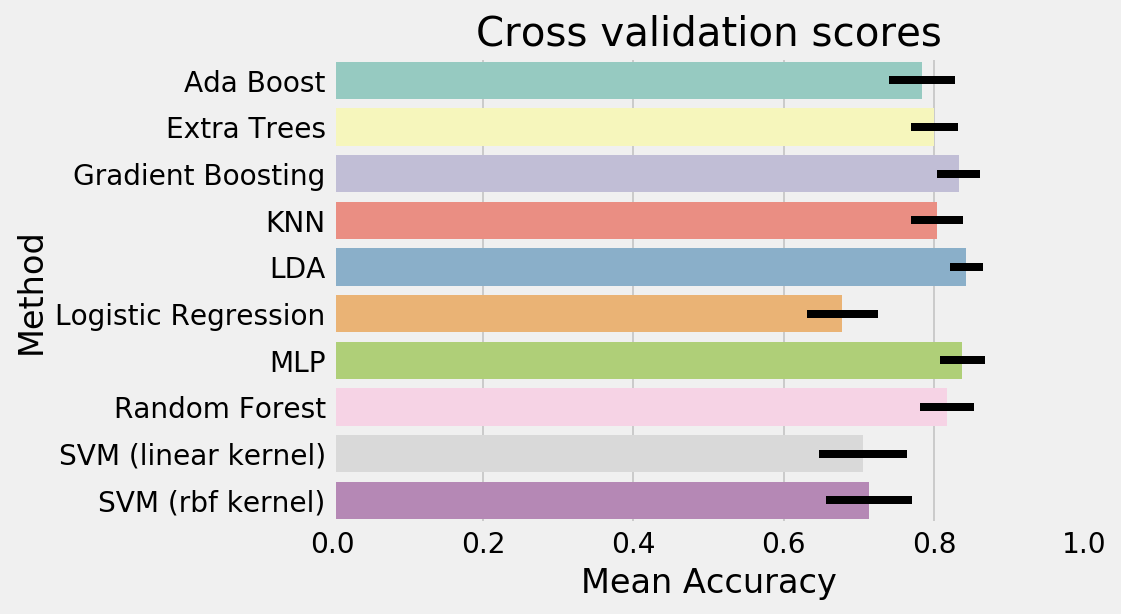

In [1401]:
plot_algo_results(results_binary)

### I decided to choose LDA, MLP,  RandomForest, ExtraTrees and the GradientBoosting classifiers for hyperparameter tuning, followed by  ensemble modeling.

## 2c) Hyperparameter Tuning

#### Because I am creating a model for each race, it does not make sense to hyperparameter tune all these models. Instead, I will demonstrate hyper-tuning by attempt to hypertune one model (ie. one race) only. I select the 2017 Australian Grand Prix (first race of the season). 
#### Becuase gridsearch is computationally expensive, I will conduct hyperparameter tuning on Google's Datalab instead and copy the optimal parameters here.

In [150]:
train_set1, test_set1, Xs_train1, Xs_test1, Y_train1, Y_test1 = \
    build_train_test_set(
                          status_dataset_train, status_dataset_test, [2016], [2017], index_list, \
                          target_var_list, target_var_list, 'StandardScaler', \
                          'Australian Grand Prix', races, races_dict
    )
    
print Xs_train1.shape, Xs_test1.shape, Y_train1.shape, Y_test1.shape 

(439, 13) (19, 13) (439, 1) (19, 1)


#### I need to flip the 0 and 1 labels. I have previously encoded the majority class as 1 and the minority class as 0. Since I'm interested in predicting the minority class this skews the report of the evaluation metrics in favor of whatever the majority class is. I have selected only 2 evaluation metrics: F1 score and Average Precision score because they are useful measures of success of prediction when the classes are very imbalanced. 

In [151]:
Y_train1_flip = np.logical_not(Y_train1).astype(int)
Y_train1_flip = np.array(Y_train1_flip).ravel()

In [154]:
# F1 score and 
scorers = {
    #'precision_score': make_scorer(precision_score),
    #'recall_score': make_scorer(recall_score),
    #'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'average_precision_score': make_scorer(average_precision_score)
}

In [155]:
def grid_search_wrapper(X_train, y_train, clf, param_grid, scorers, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skfold, return_train_score=True, n_jobs=-1)
    
    grid_result = grid_search.fit(X_train, y_train)
    
    best = grid_result.best_estimator_

    # summarize results
    print('Best params for {}'.format(refit_score))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    return best

### 1) Extra Trees Classifier

In [169]:
ExtC = ExtraTreesClassifier(n_jobs = njobs, random_state =rs)

ex_param_grid1 = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"],
              "class_weight": [None, 'balanced']}

#ex_best1 = grid_search_wrapper(Xs_train1, Y_train1_flip, ExtC, ex_param_grid1, scorers, refit_score='f1_score')

In [170]:
ex_best1 =  ExtraTreesClassifier(bootstrap=False, class_weight='balanced', max_depth=None, max_features=7, \
                                min_samples_leaf=10, min_samples_split=2, n_estimators=300, criterion="gini", \
                                n_jobs=njobs, random_state=rs)

In [140]:
ex_param_grid2 = {"max_depth": [None],
              "max_features": range(1,14,2),
              "min_samples_split":range(2,21,2),
              "min_samples_leaf": range(2,21,2),
              "bootstrap": [False],
              "n_estimators" :[20, 100],
              "criterion": ["gini"],
              "class_weight": [None]}

#ex_best2 = grid_search_wrapper(Xs_train1, Y_train1_flip, ExtC, ex_param_grid2, scorers, refit_score='f1_score')

In [134]:
ex_best2 =  ExtraTreesClassifier(bootstrap=False, class_weight=None, max_depth=None, max_features=11, \
                                min_samples_leaf=2, min_samples_split=8, n_estimators=20, criterion="gini", \
                                n_jobs=njobs, random_state=rs)

### 2) Random Forest Classifier

In [174]:
RFC = RandomForestClassifier(n_jobs = njobs, random_state =rs)

rf_param_grid1 = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"],
              "class_weight": [None, 'balanced']}

In [1939]:
#RFC_best1 = grid_search_wrapper(Xs_train1, Y_train1_flip, RFC, rf_param_grid1, scorers, refit_score='f1_score')

Best params for f1_score
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
            oob_score=False, random_state=12, verbose=0, warm_start=False)


In [172]:
RFC_best1 =  RandomForestClassifier(bootstrap=False, class_weight=None, max_depth=None, max_features=3, \
                                   min_samples_leaf=1, min_samples_split=2, n_estimators=300, criterion="gini", \
                                   n_jobs=njobs, random_state=rs)

In [138]:
rf_param_grid2 = {"max_depth": [None],
                  "max_features": range(9,14,2),
                  "min_samples_split": range(2,11,2),
                  "min_samples_leaf": range(2,11,2),
                  "bootstrap": [False],
                  "n_estimators" :[20, 60, 100],
                  "criterion": ["gini"],
                  "class_weight": [None]}

#RFC_best2 = grid_search_wrapper(Xs_train1, Y_train1_flip, RFC, rf_param_grid2, scorers, refit_score='f1_score')

In [136]:
RFC_best2 = RandomForestClassifier(bootstrap=False, class_weight=None, max_depth=None, max_features=11, \
                                   min_samples_leaf=2, min_samples_split=6, n_estimators=100, criterion="gini", \
                                   n_jobs=njobs, random_state=rs)

In [139]:
#RFC_best2_ap = grid_search_wrapper(Xs_train1, Y_train1_flip, RFC, rf_param_grid2, scorers, refit_score='f1_score')

RFC_best2_ap = RandomForestClassifier(bootstrap=False, class_weight=None, max_depth=None, max_features=9, \
                                      min_samples_leaf=6, min_samples_split=2, n_estimators=20, criterion="gini", \
                                      n_jobs=njobs, random_state=rs)

### 3) Gradient Boosting Classifier

In [249]:
GBC1 = GradientBoostingClassifier(max_depth=8,max_features='sqrt',subsample=0.8,random_state=rs)

n_estimators = [20, 60, 100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_test1 = dict(learning_rate=learning_rate, n_estimators=n_estimators)

In [1956]:
gb_best1 = grid_search_wrapper(Xs_train1, Y_train1_flip, GBC1, param_test1, scorers, refit_score='f1_score')

Best params for f1_score
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=12, subsample=0.8, verbose=0,
              warm_start=False)


In [1959]:
GBC2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=rs)

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(2,21,1), 'min_samples_leaf':range(2,21,1)}

gb_best2 = grid_search_wrapper(Xs_train1, Y_train1_flip, GBC2, param_test2, scorers, refit_score='f1_score')

Best params for f1_score
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=15,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=12, subsample=0.8, verbose=0,
              warm_start=False)


In [157]:
GBC3 = GradientBoostingClassifier(max_depth=9, min_samples_split=15, min_samples_leaf=4,\
                                  learning_rate=0.1, n_estimators=60, max_features='sqrt', \
                                  subsample=0.8, random_state=rs)

param_test3 = {'max_features':range(1,14,1)}

gb_best3 = grid_search_wrapper(Xs_train1, Y_train1_flip, GBC3, param_test3, scorers, refit_score='f1_score')

Best params for f1_score
Best: 0.491753 using {'max_features': 3}


### 4) MLP

In [208]:
samples_no = Xs_train1.shape[0]
alpha = range(2,11)
input_neurons = Xs_train1.shape[1]
output_neurons = len(np.unique(Y_train1_flip))
hidden_neurons = [samples_no / (i * (input_neurons + output_neurons)) for i in alpha]

In [234]:
hidden_neurons = range(2,13, 1)
hidden_layer_sizes = [(i,) for i in np.unique(hidden_neurons)]
hidden_layer_sizes_2 =[(i,i) for i in np.unique(hidden_neurons)]
hidden_layer_sizes_3 =[(i,i,i) for i in np.unique(hidden_neurons)]
hidden_layer_sizes_2 =[(i,i) for i in np.unique(hidden_neurons)]
hidden_layer_sizes.extend(hidden_layer_sizes_2)
hidden_layer_sizes.extend(hidden_layer_sizes_3)

In [236]:
mlp_param_grid2  = {"solver": ['lbfgs'],
                   'hidden_layer_sizes': hidden_layer_sizes,
                   'activation': ['identity', 'logistic', 'tanh', 'relu']}

mlp_best2 = grid_search_wrapper(Xs_train1, Y_train1_flip, MLP1, mlp_param_grid2, scorers, refit_score='f1_score')

Best params for f1_score
Best: 0.511323 using {'activation': 'relu', 'solver': 'lbfgs', 'hidden_layer_sizes': (9, 9, 9)}


#### Let's save the tuned classifier objects and their corresponding grid-searched parameters (Grid-searching is a terribly long process and we don't want to lose the results!)

In [175]:
import cPickle

# save the classifier
def save_classifier(var, filename):
    with open(filename, 'wb') as fid:
        cPickle.dump(var, fid) 
        
save_classifier(ex_best1, 'ex_best1.pickle')
save_classifier(ex_best2, 'ex_best2.pickle')
save_classifier(RFC_best1, 'RFC_best1.pickle')
save_classifier(RFC_best2, 'RFC_best2.pickle')
save_classifier(RFC_best2_ap, 'RFC_best2_ap.pickle')
save_classifier(gb_best3, 'gb_best3.pickle')
save_classifier(mlp_best1, 'mlp_best1.pickle')

save_classifier(ex_param_grid1, 'ex_param_grid1.pickle')
save_classifier(ex_param_grid2, 'ex_param_grid2.pickle')
save_classifier(rf_param_grid1, 'rf_param_grid1.pickle')
save_classifier(rf_param_grid2, 'rf_param_grid2.pickle')

## 2d) First-Level Predictions (Without hyperparameter tuning)

In [1413]:
sel_classifiers = [
    
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight='balanced')],
    ['KNN', KNeighborsClassifier(n_jobs=njobs, n_neighbors=1)],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', MLPClassifier(random_state=rs)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
]

In [1816]:
results_binary_test, pred_binary_test = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', sel_classifiers, samplers, skfold, races, races_dict, meta_learner \
)

In [1473]:
# Refer to jupyter notebook titled "Formula 1 Prediction Results" for full results and evauluation!

results_binary_test.to_pickle(os.path.join(directory,  "results_binary_test.pickle"))
pred_binary_test.to_pickle(os.path.join(directory,  "pred_binary_test.pickle"))

In [1444]:
results_binary_test[results_binary_test['Test accuracy'] > results_binary_test['Baseline accuracy']]

,Index,Target Var,Method,Resampler,Baseline accuracy,Test accuracy,F1 Score,Recall,Precision
0,Australian Grand Prix,statusId,Gradient Boosting,No Sampling,0.631579,0.684211,"[0.25, 0.8]","[0.142857142857, 1.0]","[1.0, 0.666666666667]"
0,Chinese Grand Prix,statusId,Random Forest,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,KNN,No Sampling,0.789474,0.842105,"[0.4, 0.909090909091]","[0.25, 1.0]","[1.0, 0.833333333333]"
0,Chinese Grand Prix,statusId,LDA,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,MLP,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,Extra Trees,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Bahrain Grand Prix,statusId,MLP,No Sampling,0.650000,0.700000,"[0.4, 0.8]","[0.285714285714, 0.923076923077]","[0.666666666667, 0.705882352941]"
0,Singapore Grand Prix,statusId,Random Forest,No Sampling,0.600000,0.650000,"[0.363636363636, 0.758620689655]","[0.25, 0.916666666667]","[0.666666666667, 0.647058823529]"
0,Singapore Grand Prix,statusId,LDA,No Sampling,0.600000,0.650000,"[0.222222222222, 0.774193548387]","[0.125, 1.0]","[1.0, 0.631578947368]"
0,Singapore Grand Prix,statusId,MLP,No Sampling,0.600000,0.650000,"[0.222222222222, 0.774193548387]","[0.125, 1.0]","[1.0, 0.631578947368]"


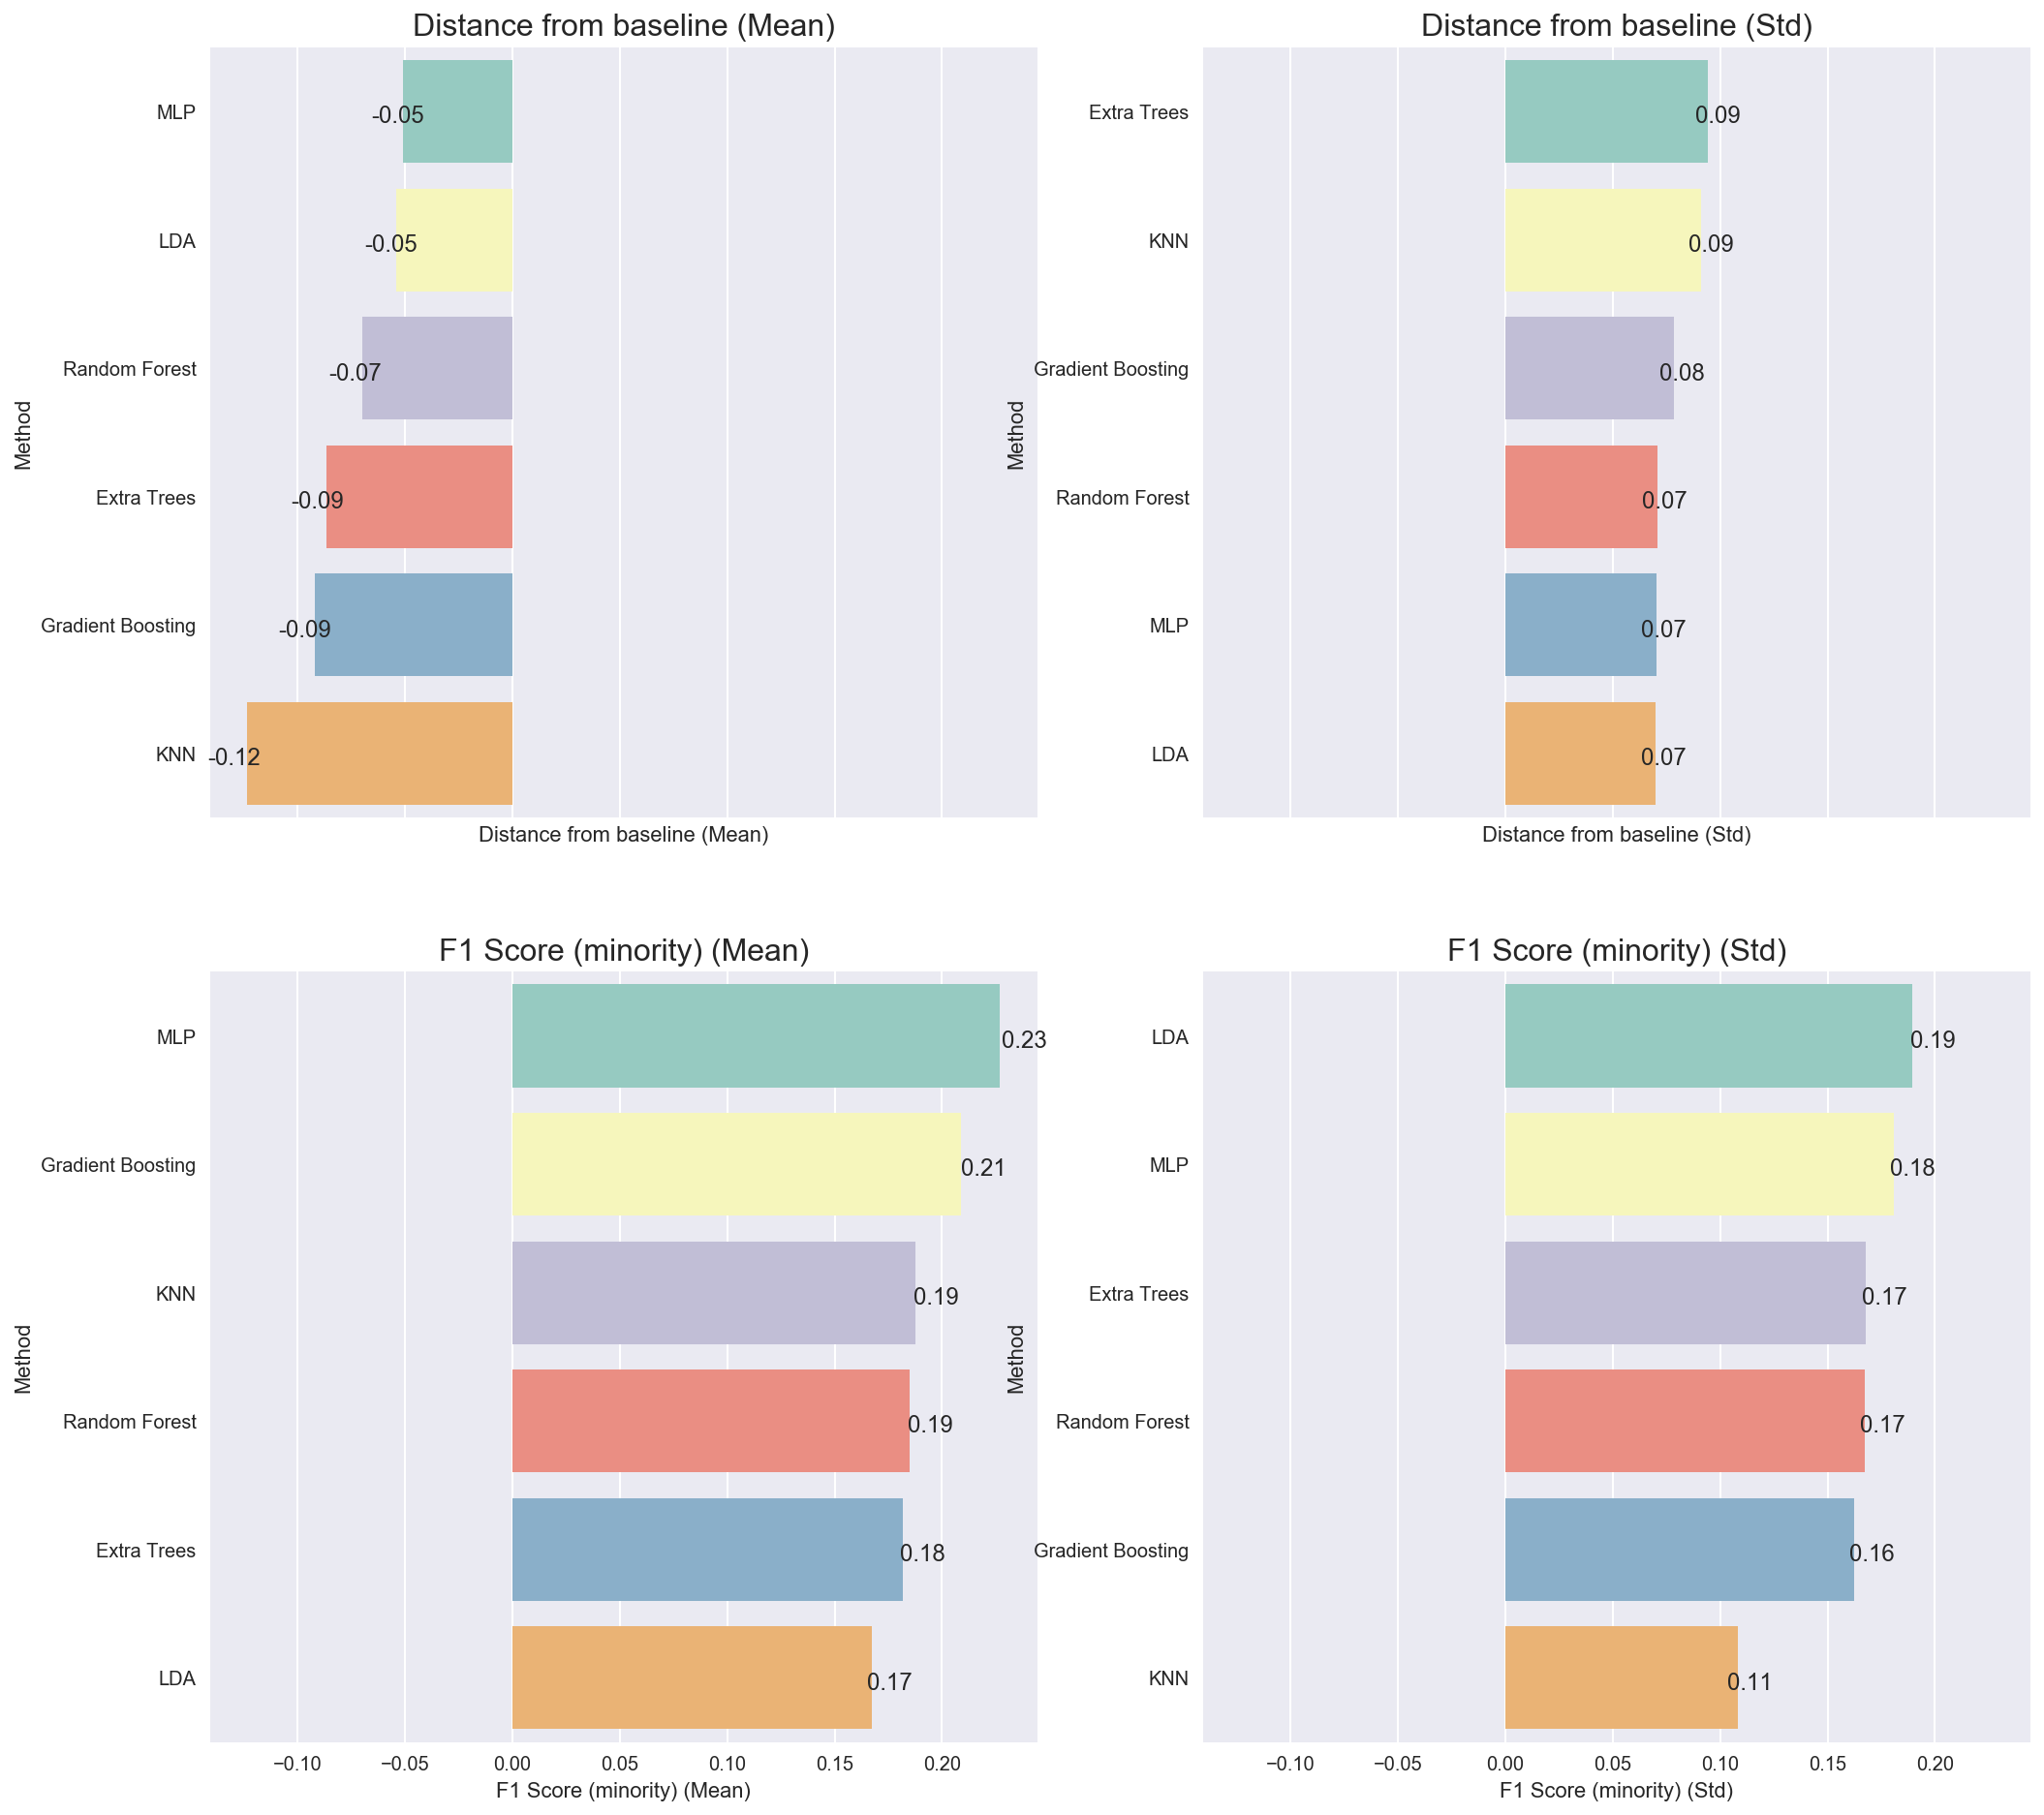

In [1931]:
metrics_list = ["Distance from baseline", "F1 Score (minority)"]
rbt = plot_algo_results(results_binary_test, "Method", metrics_list, 'desc')

#### Evaluation: Only a few races have prediction accuracy beyond baseline

## First-Level Predictions (With hyperparameter tuning)

In [239]:
tuned_classifiers = [
    
    ['Extra Trees 1', ex_best1],
    ['Extra Trees 2', ex_best2],
    ['Random Forest 1', RFC_best1],
    ['Random Forest 2', RFC_best2],
    ['Random Forest (AP)', RFC_best2_ap],
    ['Gradient Boosting', gb_best3],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', mlp_best2],
]

In [240]:
results_binary_test_tuned, pred_binary_test_tuned = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', tuned_classifiers, samplers, skfold, races, races_dict, meta_learner=""\
)

In [241]:
results_binary_test_tuned[results_binary_test_tuned['Test accuracy'] > results_binary_test_tuned['Baseline accuracy']]

,Index,Target Var,Method,Resampler,Baseline accuracy,Test accuracy,F1 Score,Recall,Precision
0,Australian Grand Prix,statusId,Random Forest 2,No Sampling,0.631579,0.736842,"[0.444444444444, 0.827586206897]","[0.285714285714, 1.0]","[1.0, 0.705882352941]"
0,Australian Grand Prix,statusId,Random Forest (AP),No Sampling,0.631579,0.684211,"[0.25, 0.8]","[0.142857142857, 1.0]","[1.0, 0.666666666667]"
0,Australian Grand Prix,statusId,Gradient Boosting,No Sampling,0.631579,0.684211,"[0.25, 0.8]","[0.142857142857, 1.0]","[1.0, 0.666666666667]"
0,Chinese Grand Prix,statusId,Extra Trees 2,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,Random Forest 1,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,Random Forest (AP),No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,Gradient Boosting,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,LDA,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Chinese Grand Prix,statusId,MLP,No Sampling,0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Bahrain Grand Prix,statusId,Extra Trees 1,No Sampling,0.650000,0.800000,"[0.666666666667, 0.857142857143]","[0.571428571429, 0.923076923077]","[0.8, 0.8]"


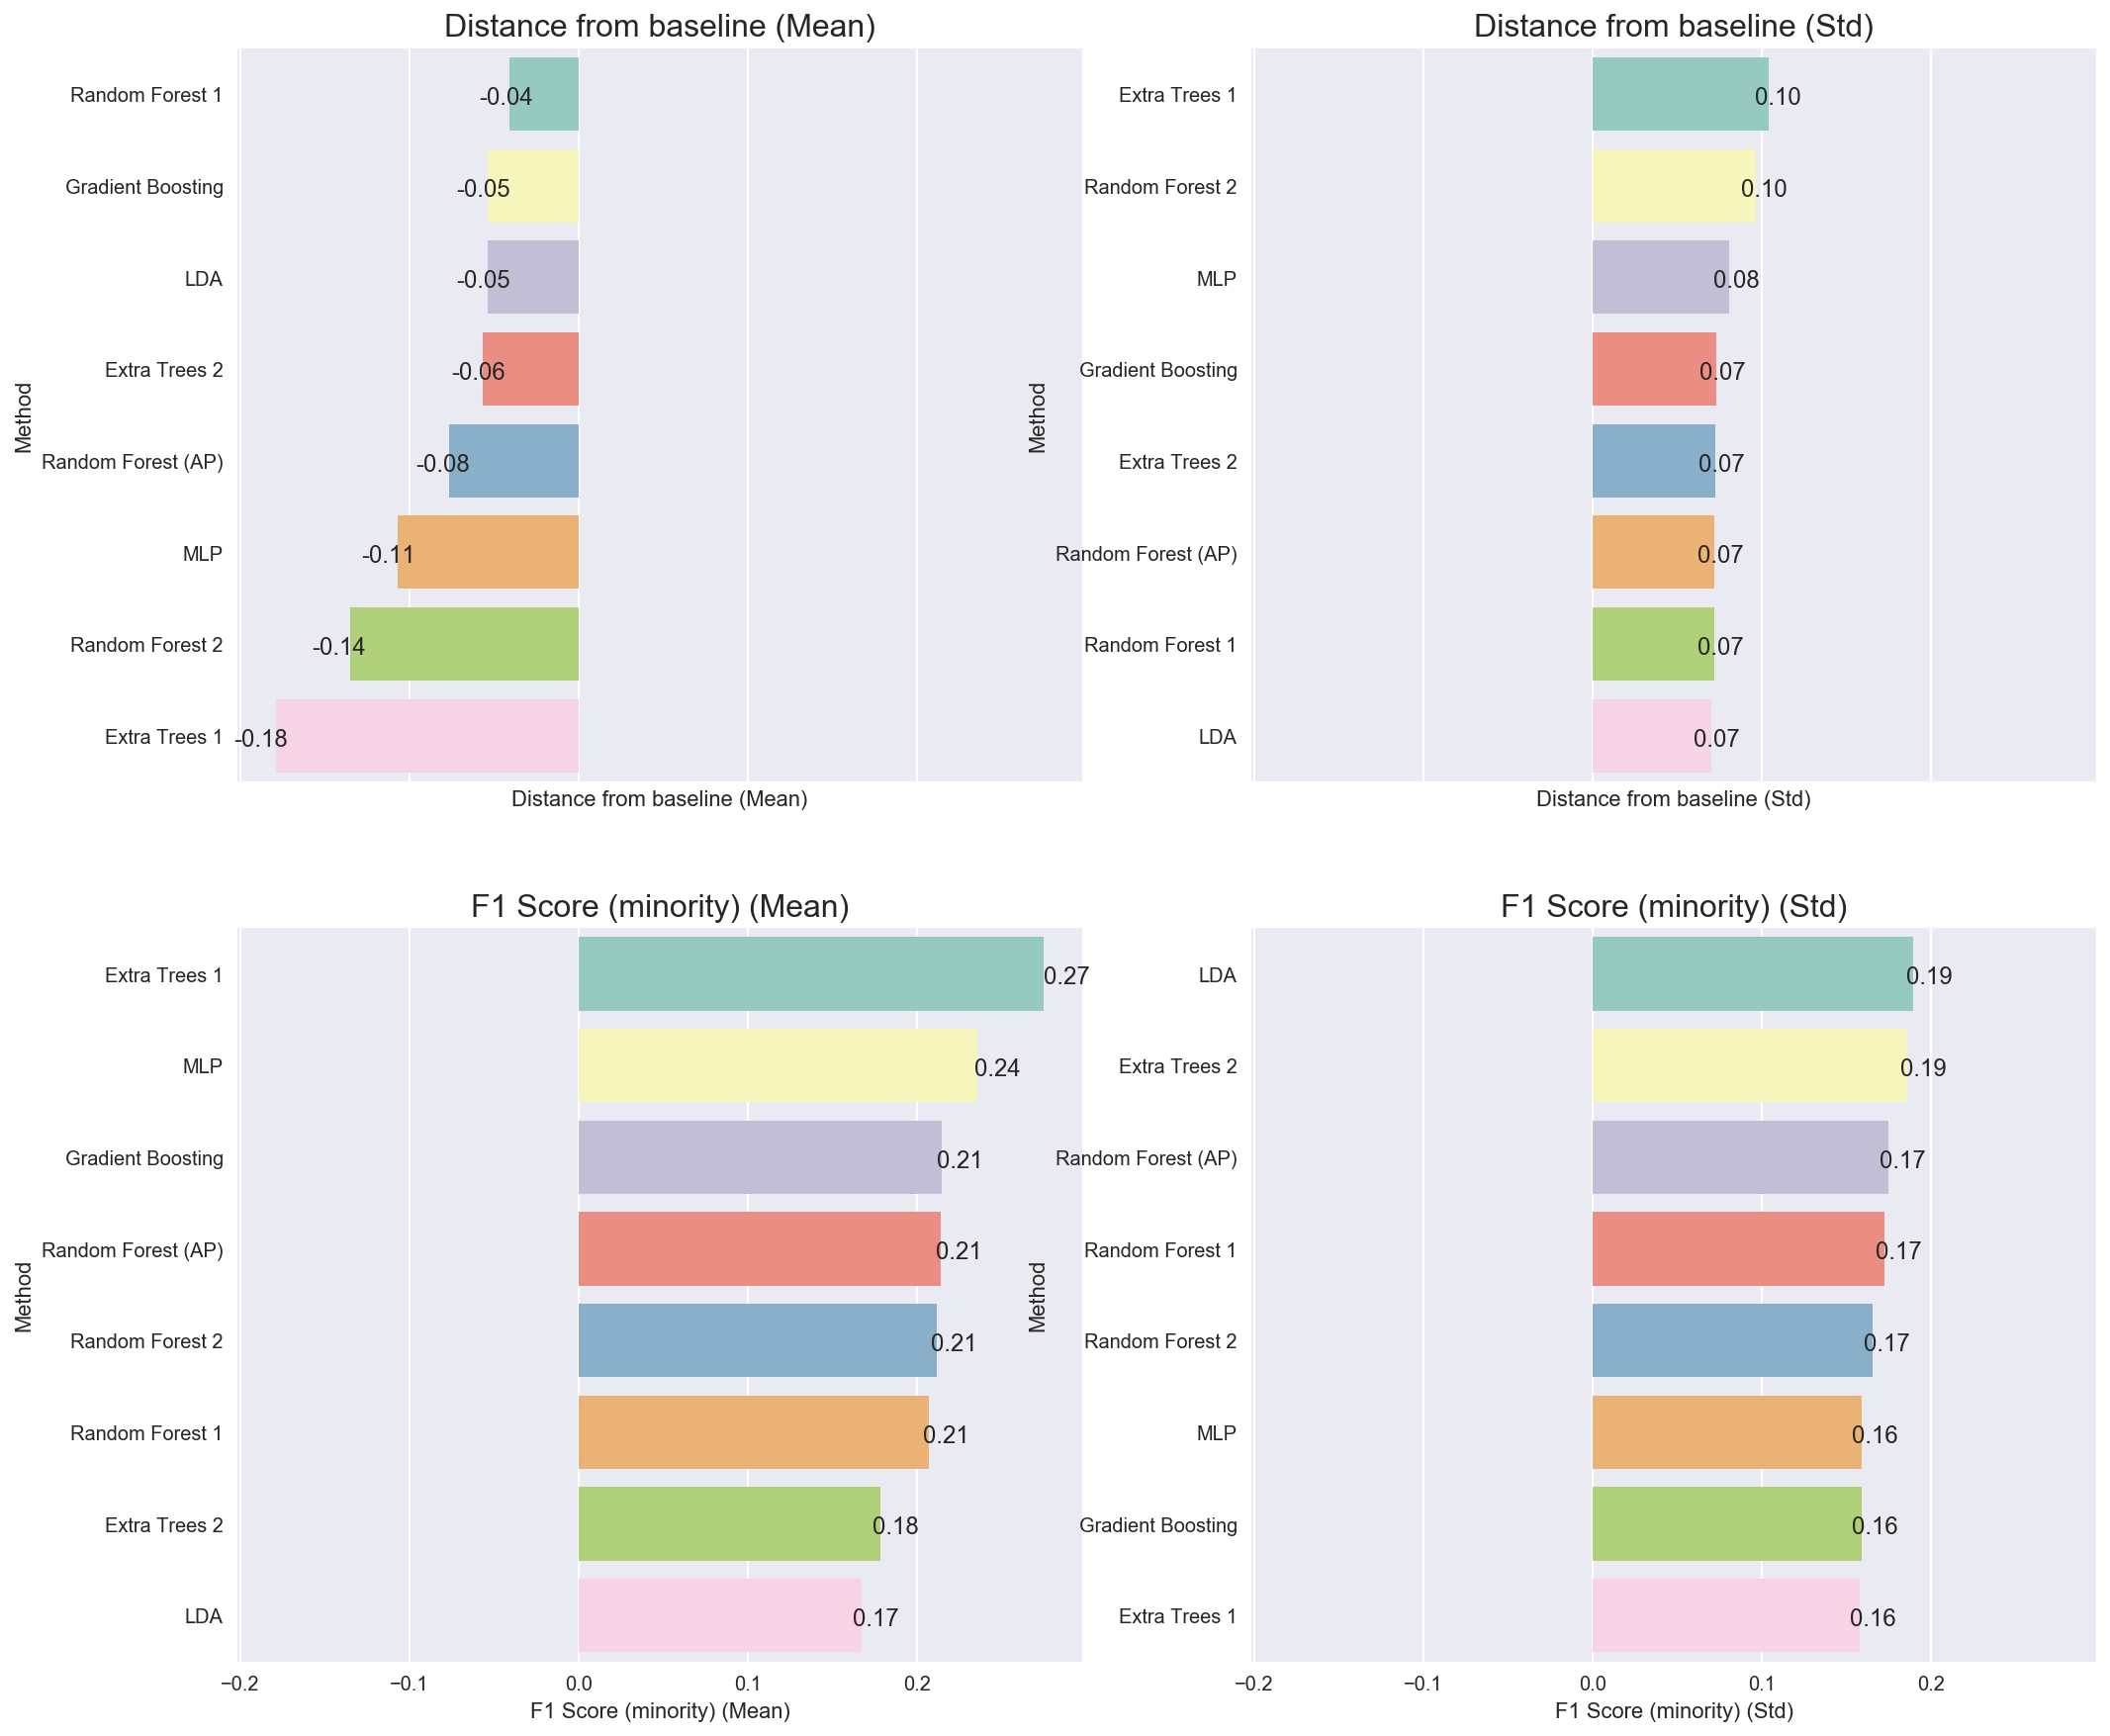

In [242]:
metrics_list = ["Distance from baseline", "F1 Score (minority)"]
rbtt = plot_algo_results(results_binary_test_tuned, "Method", metrics_list, 'desc')

### Feature importance of tree based classifiers

- Let's select one race (ie. one model) to visualize. I choose the Australian Grand Prix

In [183]:
cols_f = np.setdiff1d(train_set1.columns, np.array(['year','name', 'driverRef', 'statusId']))
train_set1_plot = train_set1.loc[:, cols_f]

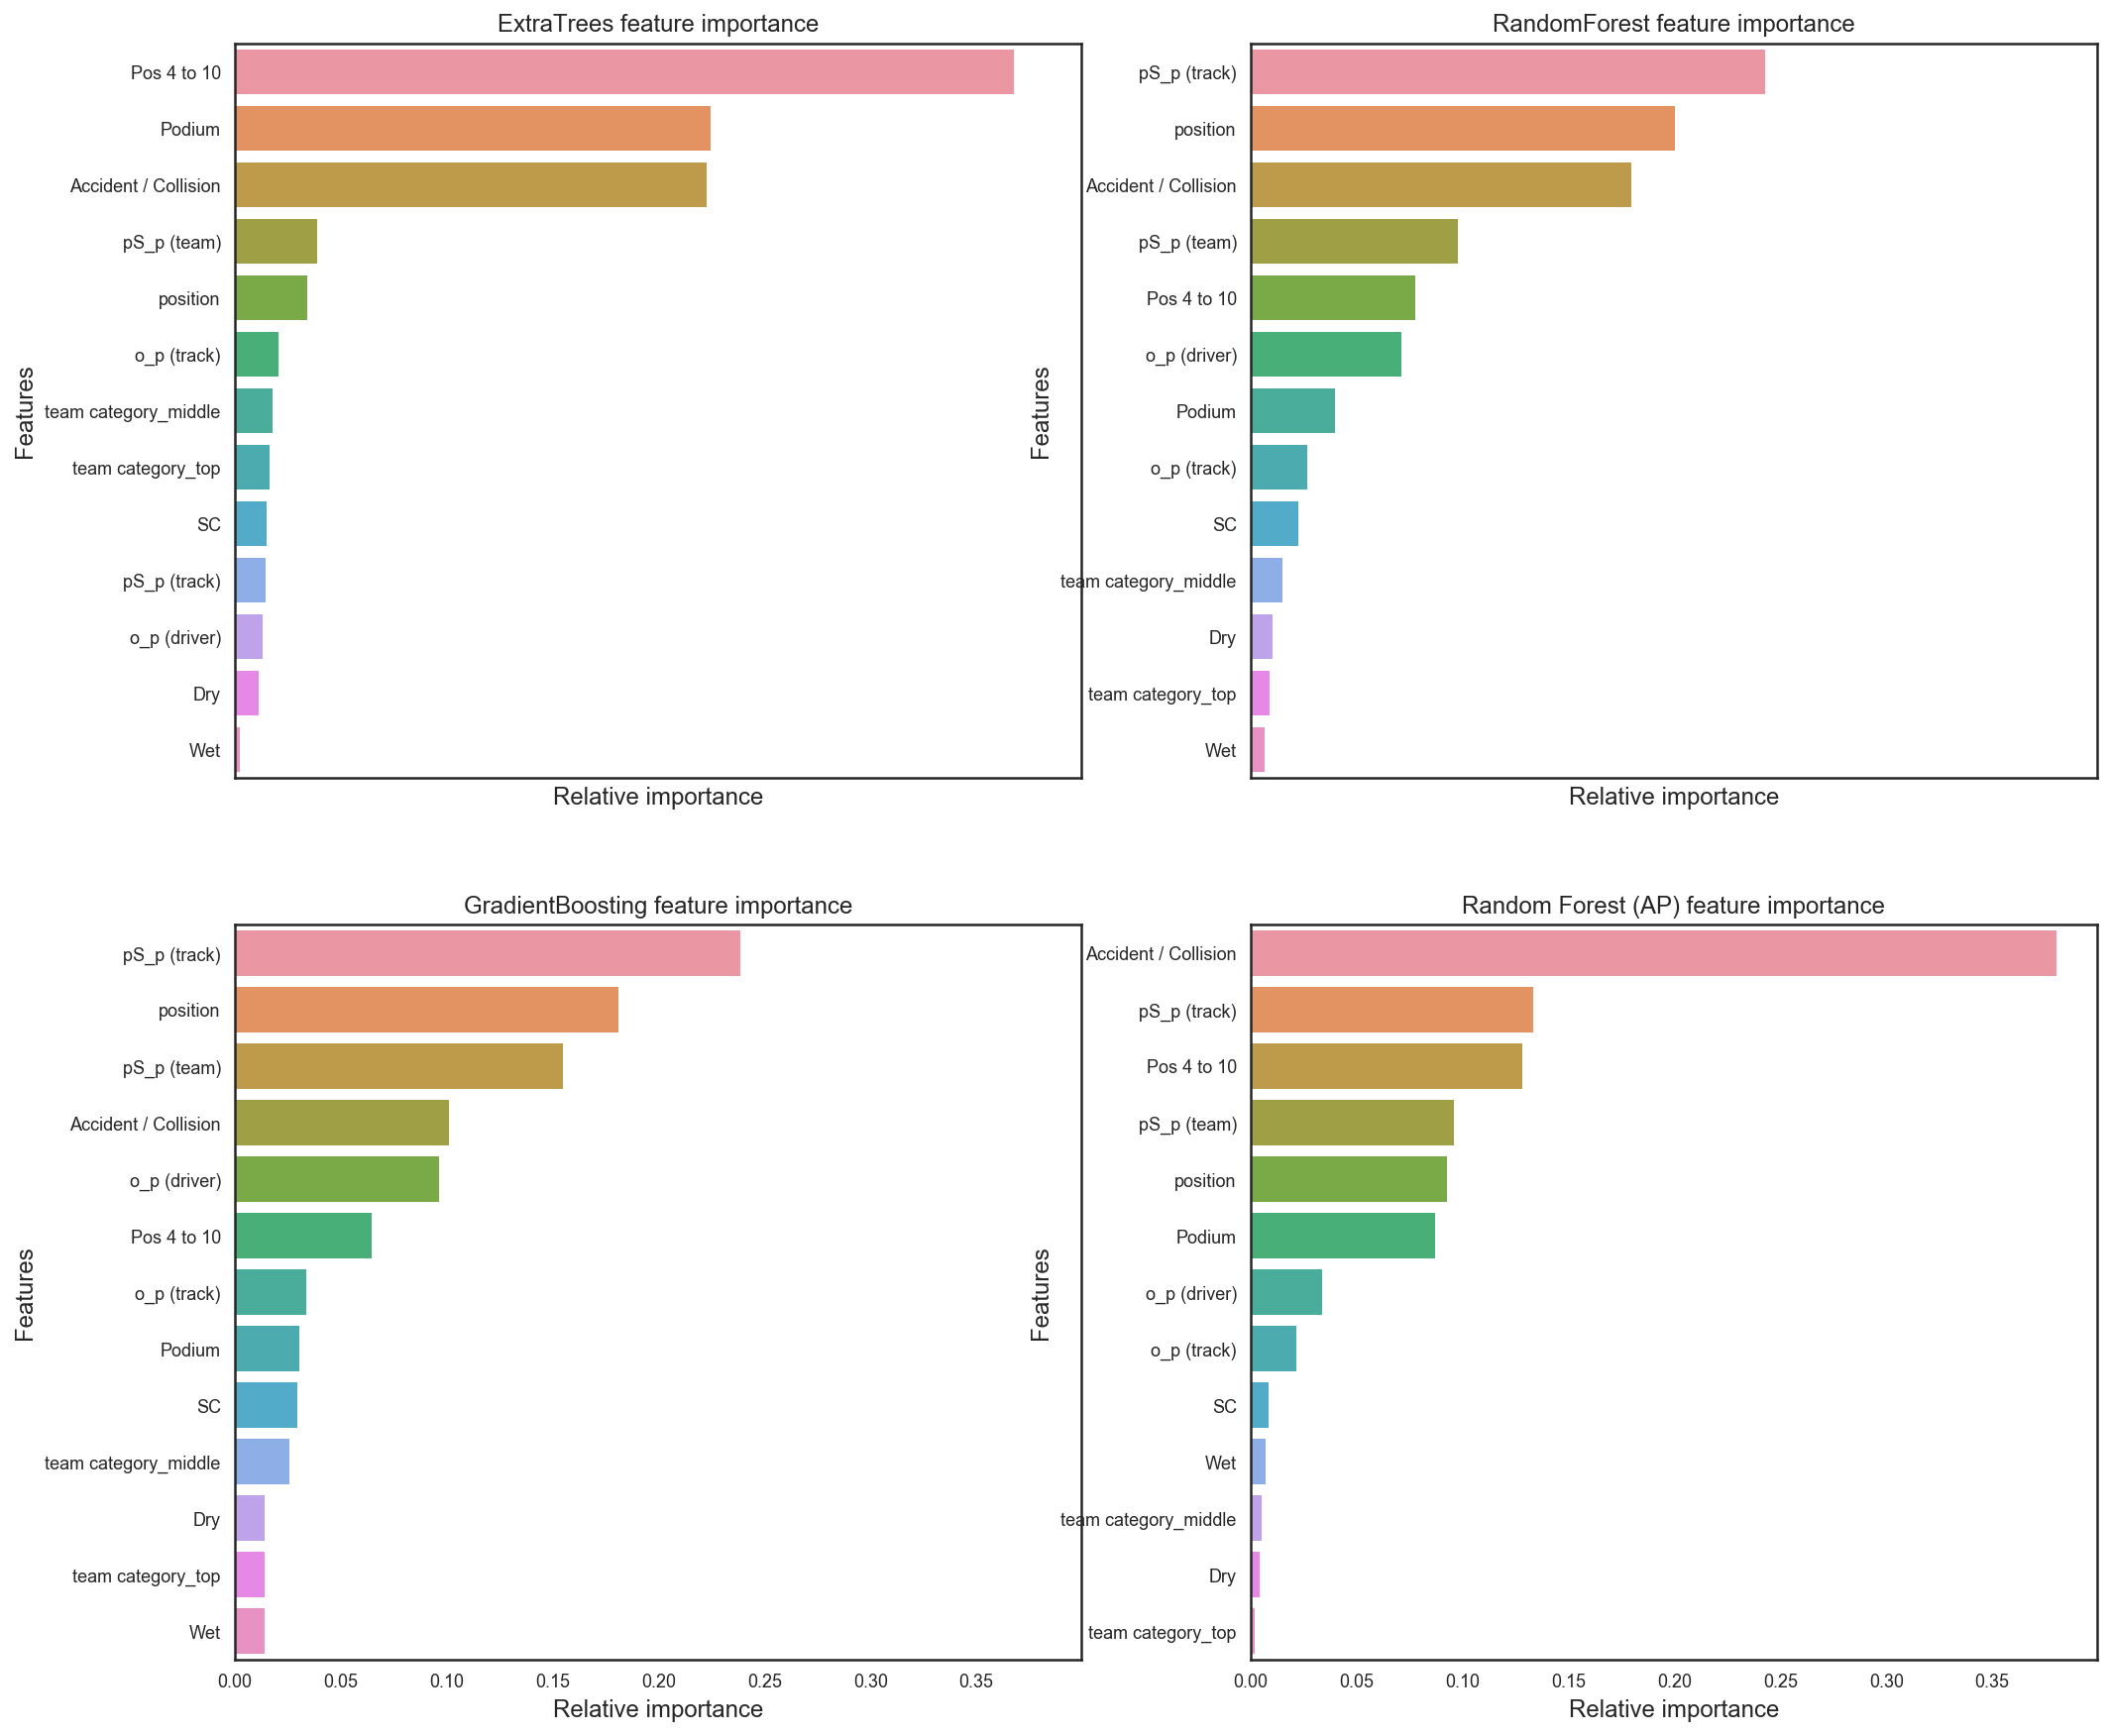

In [195]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("ExtraTrees",ex_best1),("RandomForest",RFC_best1),("GradientBoosting",gb_best3), ('Random Forest (AP)', RFC_best2_ap)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_set1_plot.columns[indices][:40], x = classifier.feature_importances_[indices][:40] ,\
                        orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

### Check correlation of first-level prediction results amongst various models

In [243]:
test_ExT_1 = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'Extra Trees 1'][['predicted']]\
                                .rename(columns={'predicted': 'ExT 1'})
test_ExT_2 = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'Extra Trees 2'][['predicted']]\
                                .rename(columns={'predicted': 'ExT 2'})
test_RF_1 = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'Random Forest 1'][['predicted']]\
                                .rename(columns={'predicted': 'RF 1'})
test_RF_2 = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'Random Forest 2'][['predicted']]\
                                .rename(columns={'predicted': 'RF 2'})
test_LDA = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'LDA'][['predicted']]\
                                .rename(columns={'predicted': 'LDA'})
test_MLP = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'MLP'][['predicted']]\
                                .rename(columns={'predicted': 'MLP'})
test_GB = pred_binary_test_tuned[pred_binary_test_tuned['classifier'] == 'Gradient Boosting'][['predicted']]\
                                .rename(columns={'predicted': 'GB'})

# Concatenate all classifier results
ensemble_results = pd.concat([test_ExT_1, test_ExT_2, test_RF_1, test_RF_2, test_GB, test_LDA, test_MLP],axis=1)

# Also concat the index

In [274]:
ensemble_results.shape

(391, 7)

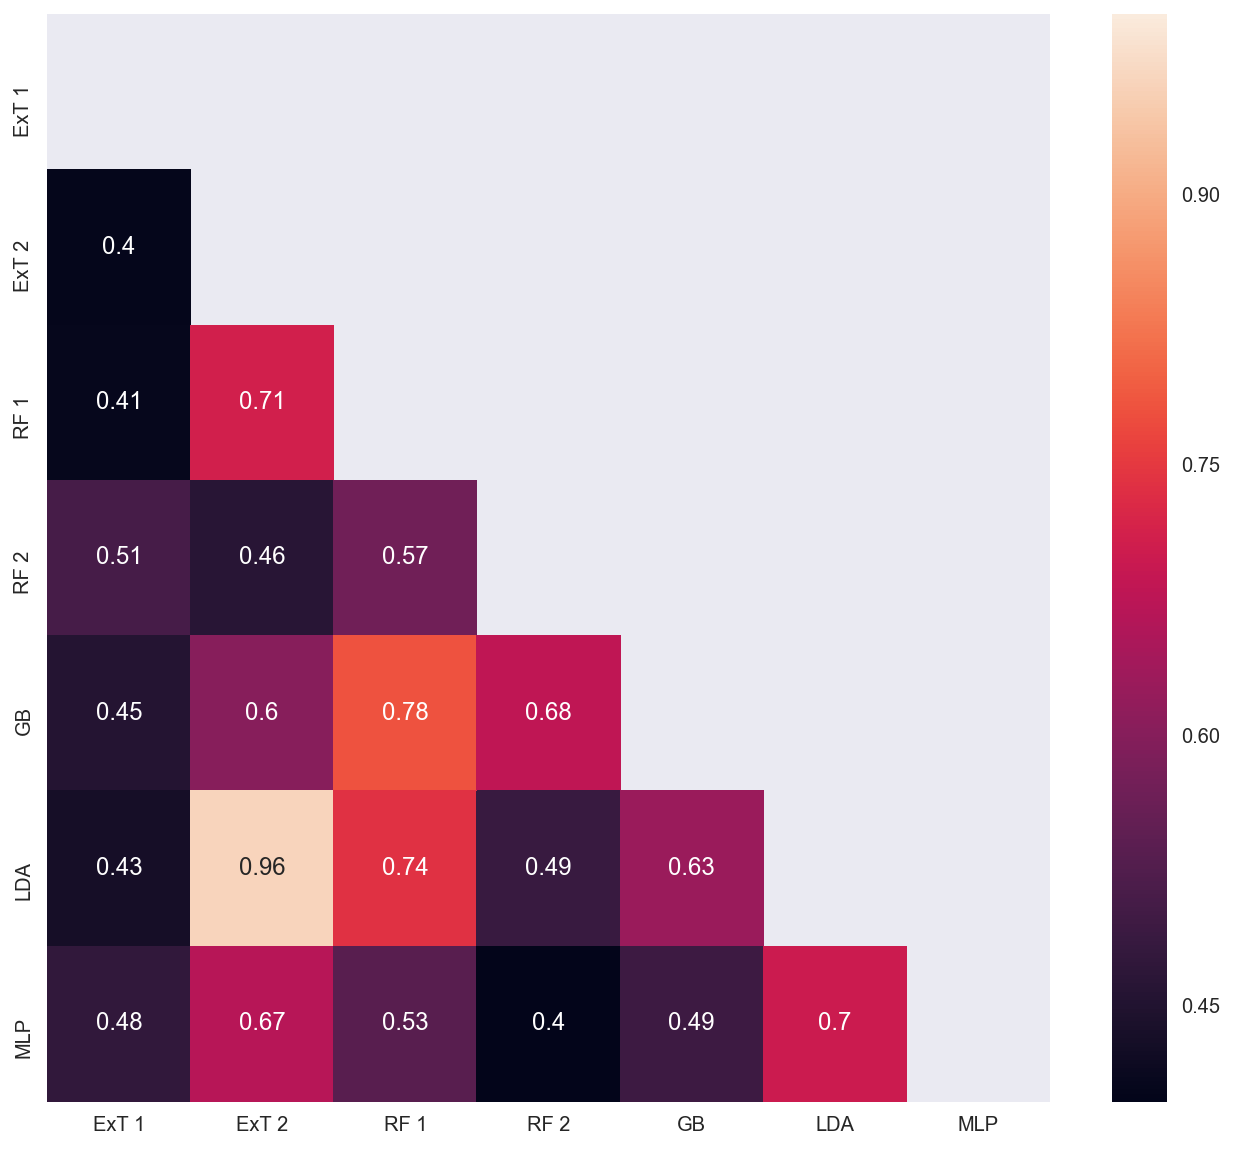

In [244]:
# Use heatmap to check for correlation

def gen_mask(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True         
    return mask

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ensemble_results.corr(), mask=gen_mask(ensemble_results.corr()), annot=True, ax=ax)

### Ensemble Stacking: Second-Level Predictions from the First-level Output using XGBoost

In [247]:
# Use XGBoost as the meta learner

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(seed = rs)

#### Ensemble Stacking: With all features (including original features + meta-features) and looping through previously tuned classifiers

In [276]:
results_binary_ensemble, pred_binary_test_ensemble = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', tuned_classifiers, samplers, skfold, races, races_dict, gbm, stacking=True, ensb_use_all=True 
)


In [278]:
results_binary_ensemble[results_binary_ensemble['Test accuracy'] > results_binary_ensemble['Baseline accuracy']]

,Index,Target Var,Method,Baseline accuracy,Test accuracy,F1 Score,Recall,Precision
0,Chinese Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Singapore Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.600000,0.700000,"[0.4, 0.8]","[0.25, 1.0]","[1.0, 0.666666666667]"
0,United States Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789474,0.842105,"[0.4, 0.909090909091]","[0.25, 1.0]","[1.0, 0.833333333333]"


#### Ensemble Stacking: Only meta-features

In [280]:
results_meta_ensemble, pred_meta_test_ensemble = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', tuned_classifiers, samplers, skfold, races, races_dict, gbm, stacking=True, ensb_use_all=False 
)

In [281]:
# No differences in ensemble stacking with and without 
results_meta_ensemble[results_meta_ensemble['Test accuracy'] > results_meta_ensemble['Baseline accuracy']]

,Index,Target Var,Method,Baseline accuracy,Test accuracy,F1 Score,Recall,Precision
0,Chinese Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789474,0.842105,"[0.571428571429, 0.903225806452]","[0.5, 0.933333333333]","[0.666666666667, 0.875]"
0,Singapore Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.600000,0.700000,"[0.4, 0.8]","[0.25, 1.0]","[1.0, 0.666666666667]"
0,United States Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789474,0.842105,"[0.4, 0.909090909091]","[0.25, 1.0]","[1.0, 0.833333333333]"


In [1585]:
results_meta_ensemble

,Index,Target Var,Method,Baseline accuracy,Test accuracy,F1 Score,Recall,Precision
0,Australian Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.631579,0.631579,"[0.222222222222, 0.758620689655]","[0.142857142857, 0.916666666667]","[0.5, 0.647058823529]"
0,Chinese Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.789474,0.842105,"[0.4, 0.909090909091]","[0.25, 1.0]","[1.0, 0.833333333333]"
0,Bahrain Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.650000,0.550000,"[0.307692307692, 0.666666666667]","[0.285714285714, 0.692307692308]","[0.333333333333, 0.642857142857]"
0,Russian Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.800000,0.750000,"[0.0, 0.857142857143]","[0.0, 0.9375]","[0.0, 0.789473684211]"
0,Spanish Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.800000,0.700000,"[0.0, 0.823529411765]","[0.0, 0.875]","[0.0, 0.777777777778]"
0,Monaco Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.684211,0.526316,"[0.181818181818, 0.666666666667]","[0.166666666667, 0.692307692308]","[0.2, 0.642857142857]"
0,Canadian Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.750000,0.600000,"[0.2, 0.733333333333]","[0.2, 0.733333333333]","[0.2, 0.733333333333]"
0,Azerbaijan Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.650000,0.500000,"[0.166666666667, 0.642857142857]","[0.142857142857, 0.692307692308]","[0.2, 0.6]"
0,Austrian Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.800000,0.600000,"[0.2, 0.733333333333]","[0.25, 0.6875]","[0.166666666667, 0.785714285714]"
0,British Grand Prix,statusId,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.850000,0.700000,"[0.25, 0.8125]","[0.333333333333, 0.764705882353]","[0.2, 0.866666666667]"


In [284]:
pred_meta_test_ensemble[pred_meta_test_ensemble['name'] == 'Singapore Grand Prix']

,year,name,driverRef,actual,predicted,tyre
0,2017,Singapore Grand Prix,vettel,0.0,1,statusId
1,2017,Singapore Grand Prix,hamilton,1.0,1,statusId
2,2017,Singapore Grand Prix,bottas,1.0,1,statusId
3,2017,Singapore Grand Prix,raikkonen,0.0,1,statusId
4,2017,Singapore Grand Prix,verstappen,0.0,1,statusId
5,2017,Singapore Grand Prix,massa,1.0,1,statusId
6,2017,Singapore Grand Prix,perez,1.0,1,statusId
7,2017,Singapore Grand Prix,sainz,1.0,1,statusId
8,2017,Singapore Grand Prix,ocon,1.0,1,statusId
9,2017,Singapore Grand Prix,hulkenberg,0.0,0,statusId


### Evaluation of results:
- Only 3 out of 20 races in 2016 season achieved predicion accuracy above baseline using XGBoost Classifier together with ensemble stacking. 
- Hyperparameter tuning showed promise in improving prediction accuracy. 

### Next Steps:
- Peform classifier tuning for more models instead of just a single chosen mode; (2017 Australian Grnd Prix)
- Tune the XGBoost classifier too.